# DSFB Course Project: Predicting IPO Share Price

## Introduction

An Initial Public Offering (IPO) is the process by which a private company becomes publicly traded on a stock exchange. The IPO company offers its shares to public investors in exchange of capital for sustaining expansion and growth. For this reason, IPOs are often issued by small or young companies, but they can also be done by large  companies looking to become publicly traded. During an IPO, the company obtains the assistance of an investment bank (underwriter), which helps determine the type, amount and price of the shares being offered. Decisions about the offering price are particularly important to avoid incurring excessive costs and maximize the capital received in the IPO. However at the end of the first trading day, price of each share can change due to market dynamics, which can lead to a price higher or lower than the offering one.

During an Initial Public Offering (IPO), the firm’s management have to disclose all relevant information about their business in a filing with the government called the "IPO Prospectus." Although there might be concerns about the public disclosure of sensitive information in the Prospectus that can help competitors, firms are encouraged to be as transparent as possible in order to avoid future litigation (lawsuits). A key textual field from the prospectus is:

__Risk_Factors__: Firms have to disclose all relevant information about internal or external risk factors that might affect future business performances. This information is contained in the “Risk Factors” section of the IPO prospectus. 

The key pricing variables are:

__Offering_Price__: the price at which a company sells its shares to investors.

__Num_Shares__: the total number of outstanding shares.

__Closing_Price__: (at the end of the first day of training) price at which shares trade in the open market, measured at the end of the first day of trading.

In this project you are provided with IPO data of different firms that are collected from different sources. You can find the dataset under project directory in the course git repository under the name of *ipo.xlsx*. The description of other variables can be found in *variable_description.xlsx*.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### The goal is to predict whether the share price will be higher by the end of the 1st day of IPO. At first, this is done without considering Risks_Factors that are communicated by the firms in the IPO report. The second part will consist in predicting the Price Increase by only using the Risk_Factors feature. Finally the prediction will be done by using all fields. At last part, the model will try to estimate the share price at the end of the day.
### The data will be preprocessed once for all the parts.

# Data Loading - Preprocessing

<b> Loading

In [2]:
#Data Importation from Excel Sheet:
raw_data = pd.read_excel('ipo.xlsx')
print(raw_data.shape)

(3000, 154)


<b>Exploration

First contact with categorical values:

In [3]:
print(raw_data.info())
print()
print(raw_data.select_dtypes(include = 'object').columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 154 entries, ID to Num_Shares
dtypes: datetime64[ns](3), float64(91), int64(13), object(47)
memory usage: 3.5+ MB
None

Index(['ID', 'Risk_Factors', 'mgt_fee', 'exch', 'mgrs_role', 'mgrs', 'all_sic',
       'amd_date', 'auditor', 'br', 'city', 'description', 'round_tot',
       'gross_spread', 'ht_ind', 'ht_ind_gr', 'industry', 'ind_group',
       'price_range', 'issuer', 'veic_descr', 'legal', 'naic_primary',
       'naic_decr', 'public_descr', 'lockup_date', 'lockup_days',
       'lockup_flag', 'sic_main', 'nation', 'lbo', 'prim_naic', 'prim_uop',
       'pe_backed', 'shs_out_after', 'state', 'uop', 'vc', 'zip',
       'min_round_vexp', 'avg_round_vexp', 'max_round_vexp',
       'min_firm_amt_vexp', 'avg_firm_amt_vexp', 'max_firm_amt_vexp',
       'min_fund_amt_vexp', 'max_fund_amt_vexp'],
      dtype='object')


First contact with the feature "Risk_Factors":

In [4]:
np.shape(raw_data['Risk_Factors'].value_counts())

(2999,)

All Risks are unique and seem to correspond to the communication of the company through the IPO report.

In [5]:
print('Info on NaN in Closing Price: ')
print(raw_data['Closing_Price'].isnull().value_counts())

print('Info on NaN & unicity in ID: ')
print(raw_data['ID'].nunique())
print(raw_data['ID'].isnull().value_counts())

raw_data.set_index('ID', drop = True, inplace = True)
raw_data.head(3)

Info on NaN in Closing Price: 
False    3000
Name: Closing_Price, dtype: int64
Info on NaN & unicity in ID: 
3000
False    3000
Name: ID, dtype: int64


,Closing_Price,Offering_Price,Risk_Factors,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,...,num_funds_vexp,min_round_vexp,avg_round_vexp,max_round_vexp,min_firm_amt_vexp,avg_firm_amt_vexp,max_firm_amt_vexp,min_fund_amt_vexp,max_fund_amt_vexp,Num_Shares
ID,,,,,,,,,,,,,,,,,,,,,
000307,18.50,15.0,>risk factors \ninvesting in our common stock ...,Comb.,-2.05,0.0,0.0,0.0,-3.07,-5.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20673000
000833,12.85,13.0,risk factors an investment in our common stock...,Comb.,-0.50,0.0,0.0,0.0,-0.13,-1.19,...,5.0,60'000.0,108'666.7,140'000.0,35'000.0,65'200.0,105'000.0,35'000.0,105'000.0,36762000
00086T,16.50,15.0,RISK FACTORS In addition to the other informat...,0.21,2.72,7.1,25.0,15.4,3.99,3.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7000000


<b>Drop Features with too many (> 50 %) missing values

In [6]:
#Missing Values Exploration
raw_data.isna().sum().describe()

count     153.000000
mean      352.267974
std       570.435648
min         0.000000
25%         0.000000
50%        14.000000
75%       563.000000
max      2495.000000
dtype: float64

In [7]:
#Dropping columns having more than 50% of missing values
reduced_features_data = raw_data.dropna(axis = 'columns', thresh = 1500)
reduced_features_data.shape

(3000, 147)

In [8]:
#Missing Values Exploration
reduced_features_data.isna().sum().describe()      

count     147.000000
mean      284.278912
std       464.098002
min         0.000000
25%         0.000000
50%        10.000000
75%       456.000000
max      1437.000000
dtype: float64

<b> Introducing the difference between Closing and Initial Offering : 

In [9]:
reduced_features_data['Price_Increase'] = (reduced_features_data['Closing_Price']-reduced_features_data['Offering_Price'])

<b>The dataset now counts 148 features. The next step is to explore the data to catch their nature (numerical, categorical...) before doing anything.

In [10]:
reduced_features_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 000307 to 8A7067
Columns: 148 entries, Closing_Price to Price_Increase
dtypes: datetime64[ns](3), float64(86), int64(13), object(46)
memory usage: 3.4+ MB


In [11]:
#Mapping of non-numerical Features
non_numerical = reduced_features_data.select_dtypes(include = ['object']).columns
reduced_features_data[non_numerical].head(2)

,Risk_Factors,mgt_fee,exch,mgrs_role,mgrs,all_sic,amd_date,auditor,br,city,...,vc,zip,min_round_vexp,avg_round_vexp,max_round_vexp,min_firm_amt_vexp,avg_firm_amt_vexp,max_firm_amt_vexp,min_fund_amt_vexp,max_fund_amt_vexp
ID,,,,,,,,,,,,,,,,,,,,,
000307,>risk factors \ninvesting in our common stock ...,Comb.,New York,JOINT BOOK RUNNER\nJOINT BOOK RUNNER\nCO MANAGER,William Blair & Co\nRaymond James & Associates...,8093,08/15/14\n09/10/14\n09/22/14,BDO USA LLP,William Blair & Co\nRaymond James & Associates...,Brentwood,...,No,37027--754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000833,risk factors an investment in our common stock...,Comb.,New York,JOINT BOOK RUNNER\nJOINT BOOK RUNNER\nJOINT BO...,Credit Suisse\nJP Morgan\nBear Stearns & Co In...,6282/6722/6726/6799/6719/6351,06/28/06\n08/28/06\n10/03/06\n10/27/06\n11/02/06,Deloitte & Touche LLP,Credit Suisse\nJP Morgan & Co Inc\nBear Stearn...,New York,...,No,10005,60'000.0,108'666.7,140'000.0,35'000.0,65'200.0,105'000.0,35'000.0,105'000.0


In [12]:
#Mapping of numerical Features
numerical = reduced_features_data.select_dtypes(exclude = 'object')
numerical = numerical.select_dtypes(exclude = 'datetime64')
print(numerical.columns)
numerical.head(3)

Index(['Closing_Price', 'Offering_Price', 'pctchg_dj_1', 'pctchg_hp',
       'pctchg_lp', 'pctchg_mp', 'pctchg_nasdaq_1', 'pctchg_sp_1',
       'pctchg_sp_2', 'pctchg_dj_2', 'pctchg_nasdaq_2', 'pctchg_p',
       'pctchg_sp_3', 'pctchg_sp_4', 'pctchg_amd_amt', 'pct_ins_shs_aft',
       'pct_ins_shs_bef', 'mkt_cap', 'acc_fee', 'amd_hp', 'amd_lp', 'amd_mp',
       'amd_pr_shs_pct', 'amd_pr_amt', 'amd_pr_shst_tot', 'amd_shst_tot',
       'amt_filed', 'bluesky', 'book_proceeds', 'book_proceeds_ovt', 'bvps',
       'comm_eq', 'comm_eq_bef', 'dj_avg_1', 'dj_avg_2', 'date_amd',
       'date_found', 'days_in_registr', 'deal_size', 'exp_pctofproceeds',
       'exp_incl_gross', 'filing_date', 'free_float', 'gross_spread_allmkt',
       'lastamd_tot', 'legal_exp', 'mktval_aft', 'mktval_bef', 'misc_exp',
       'h_fil_p', 'l_fil_p', 'm_fil_p', 'nasdaq_avg_1', 'nasdaq_avg_2',
       'num_mgrs', 'num_amd', 'num_bokr', 'num_bokr_up', 'num_emp',
       'num_emp_date', 'num_lead_mgr', 'shs_ourst_aft_pro

,Closing_Price,Offering_Price,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,pctchg_sp_2,pctchg_dj_2,...,tot_proceeds,tot_shs_offered,underw_fee,shrout_crsp,ipo_yr_ritt,num_rounds_vexp,num_firms_vexp,num_funds_vexp,Num_Shares,Price_Increase
ID,,,,,,,,,,,,,,,,,,,,,
000307,18.50,15.0,-2.05,0.0,0.0,0.0,-3.07,-5.04,-2.77,18.74,...,75000000,5000,NaN,20673000,206,NaN,NaN,NaN,20673000,3.50
000833,12.85,13.0,-0.50,0.0,0.0,0.0,-0.13,-1.19,-0.77,-23.00,...,89681033,6898,NaN,36762000,157,3.0,5.0,5.0,36762000,-0.15
00086T,16.50,15.0,2.72,7.1,25.0,15.4,3.99,3.31,3.49,46.33,...,40500000,2700,567000.0,7000000,473,NaN,NaN,NaN,7000000,1.50


## Non Numerical Data Treatment & Encoding

One observes the following features: city, state, zip, nation. It is possible to drop some of these features are some informations are contained in others.
* The information provided by zip is contained in city, therefore, this feature is droped. State is conserved at the expanse of city to reduce the number of features after the one hot encoding
* The features state and nation could also be dropped. But as some financial variables such as taxes can be different within a nation like USA among the different states and industries, the feature state will remain.
* The information provided by the feature ind_group is contained in the feature industry, therefore, it will be dropped. The later can be derived from the feature veic_descr.

The features in next cell are dropped as we think that managers and their role may have low impact on the final results (Which is not necessarily true in real life), legal representation is less weighted than book runner and issuer and veic_descr just brings redundant information.

In [13]:
categ_feat_todrop = ['zip', 'nation', 'city', 'ind_group', 'prim_naic','naic_primary', 'amd_date', 'sic_main', 'naic_decr', 'ht_ind_gr', 'ht_ind', 'industry','issuer', 'mgrs', 'uop', 'veic_descr', 'mgrs_role', 'legal']
encoding_data = reduced_features_data.drop(columns = categ_feat_todrop)

<b>Categorical Features:

In [14]:
encoding_data.select_dtypes(include='object').describe().transpose().sort_values('unique')

,count,unique,top,freq
lockup_flag,3000,2,Yes,2475
pe_backed,3000,2,No,2439
lbo,3000,2,No,2506
vc,3000,2,No,1688
shs_out_after,3000,2,No,2540
price_range,2985,3,Within range,1847
public_descr,3000,7,Private,2304
exch,3000,22,Nasdaq,2070
prim_uop,3000,34,General Corp. Purp.,1809
state,3000,53,California,794


The 5 first features of the table above are binary (yes/no) and the 6th one (price_range) is an ordinal feature. Therefore, it will be possible to perform an One Hot Encoding on these featues.

**The feature exch is cleaned as following:**

In [15]:
encoding_data['exch'] = encoding_data['exch'].replace({'Sm Cap Mkt' : 'smcap',
                              'Sm Cap Mkt\nBoston' : 'smcap',
                             'NYSE MKT' : 'New York',
                             'NYSE Amex' : 'New York',
                             'Nasdaq\nPacific' : 'Nasdaq',
                             'NYSE Arca' : 'New York',
                             'Nasdaq\nBoston' : 'New York',
                             'New York\nToronto' : 'New York',
                             'OTC\nNasdaq' : 'OTC',
                             'NYSE Alter' : 'New York',
                             'American\nToronto' : 'OTC',
                             'Nasdaq\nToronto' : 'OTC',
                             'Sm Cap Mkt\nChicago' : 'smcap',
                             'New York\nFrankfurt' : 'dax',
                             'Boston\nSm Cap Mkt' : 'smcap',
                             'Pacific\nSm Cap Mkt\nOTC' : 'OTC',
                             'Nasdaq\nNew York' : 'Nasdaq',
                             'OTC\nAmerican' : 'OTC'})

In [16]:
encoding_data[['exch']].nunique()

exch    6
dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
exch_encoded = lab_enc.fit_transform(encoding_data.exch)
encoding_data['exch']=exch_encoded
encoding_data[['exch']].head(3)

,exch
ID,
000307,2
000833,2
00086T,1


**The features Lockup_days & gross_spread are numerical, they need to be converted so.
The feature lockup_days & gross_spread are cleaned as following:**

In [18]:
encoding_data['lockup_days'] = encoding_data['lockup_days'].str[:3].replace({'90\n':'90', '60\n':'60', '45\n':'45',
                                             '87/n':'87', '\n\n':'0', '\n90':'90',
                                             '91\n':'91', '80\n':'80','87\n':'80', '15\n':'15'})

In [19]:
#lockup_days feature is type int, so it is replaced that way :
encoding_data['lockup_days'] = encoding_data['lockup_days'].fillna('0')
encoding_data['lockup_days'] = encoding_data['lockup_days'].astype(int)
encoding_data['lockup_days'] = encoding_data['lockup_days'].replace({0:encoding_data['lockup_days'].mean()})

In [20]:
#gross_spread feature is type int, so it is replaced that way :
encoding_data['gross_spread'].describe()
encoding_data['gross_spread'] = encoding_data['gross_spread'].replace({'na':0})
encoding_data['gross_spread'] = encoding_data['gross_spread'].astype(float)
encoding_data['gross_spread'] = encoding_data['gross_spread'].replace({0:encoding_data['gross_spread'].mean()})

The vexp features are also numerical if we remove the quote :

In [21]:
num_vexp = ['min_round_vexp','avg_round_vexp', 'max_round_vexp', 'min_firm_amt_vexp', 'avg_firm_amt_vexp', 'max_firm_amt_vexp','min_fund_amt_vexp', 'max_fund_amt_vexp' ]

#removing the quotes from the vexp features to convert them to float     
for feature in num_vexp:
    encoding_data[feature] = encoding_data[feature].str.replace("\'", '')
    encoding_data[feature] = encoding_data[feature].astype(np.float64)

In [22]:
#Add the previous features to numerical features:
numerical = encoding_data.select_dtypes(exclude='object')

In [23]:
encoding_data = encoding_data.drop(columns = ['offer_date', 'lockup_date'])

In [24]:
encoding_data.select_dtypes(include='object').head(2)

,Risk_Factors,mgt_fee,all_sic,auditor,br,description,round_tot,price_range,public_descr,lockup_flag,lbo,prim_uop,pe_backed,shs_out_after,state,vc
ID,,,,,,,,,,,,,,,,
000307,>risk factors \ninvesting in our common stock ...,Comb.,8093,BDO USA LLP,William Blair & Co\nRaymond James & Associates...,"5,000,000.0 Common Shares",NaN,Above range,Private,Yes,No,Reduce Indebtedness,No,No,Tennessee,No
000833,risk factors an investment in our common stock...,Comb.,6282/6722/6726/6799/6719/6351,Deloitte & Touche LLP,Credit Suisse\nJP Morgan & Co Inc\nBear Stearn...,"6,898,541.0 Common Shares","140,000.0\n60,000.0\n126,000.0\n126,000.0\n126...",Below range,Private,Yes,Yes,General Corp. Purp.,Yes,No,New York,No


#### The feature all_sic is already included in industry description, therefore it is dropped

In [25]:
encoding_data = encoding_data.drop(columns = ['all_sic'])

**Detection of Binary / Categorical Feature based on the number of unique occurences**

In [26]:
# Useful Feature-Extraction-Fuction (FEF):
def get_feat(dico, val):
    listOfKeys = list()
    listOfItems = dico.items()
    for item  in listOfItems:
        if item[1] == val:
            listOfKeys.append(item[0])
    return  listOfKeys

In [27]:
likely_cat = {}
cat_thresh = 1/5
for feat in encoding_data.select_dtypes(include = 'object').columns:
    likely_cat[feat] = 1.*encoding_data[feat].nunique()/encoding_data[feat].count() < cat_thresh

#Extract likely categorical Features:

categ_features = get_feat(likely_cat, True)
print(categ_features)

['mgt_fee', 'auditor', 'price_range', 'public_descr', 'lockup_flag', 'lbo', 'prim_uop', 'pe_backed', 'shs_out_after', 'state', 'vc']


In [28]:
encoding_data.select_dtypes(include = 'object').describe().transpose().sort_values('unique')

,count,unique,top,freq
lockup_flag,3000,2,Yes,2475
lbo,3000,2,No,2506
pe_backed,3000,2,No,2439
shs_out_after,3000,2,No,2540
vc,3000,2,No,1688
price_range,2985,3,Within range,1847
public_descr,3000,7,Private,2304
prim_uop,3000,34,General Corp. Purp.,1809
state,3000,53,California,794
auditor,2992,124,Ernst & Young LLP,831


The feature mgt_fee contains an intrusive occurence which is unnecessary, therefore, it is replaced by the median.

In [29]:
encoding_data['mgt_fee'] = encoding_data['mgt_fee'].replace({'Comb.':'0'})
encoding_data['mgt_fee'] = encoding_data['mgt_fee'].astype(float)
mgt_med = encoding_data['mgt_fee'].median()
encoding_data['mgt_fee'] = encoding_data['mgt_fee'].replace({0:mgt_med})

In [30]:
encoding_data['mgt_fee'].describe()

count    2990.000000
mean        0.188004
std         0.070818
min         0.030000
25%         0.160000
50%         0.160000
75%         0.212750
max         1.669000
Name: mgt_fee, dtype: float64

### Here the Categorical features will be grouped by the most represented one

**Reducing the number of Auditors by keeping the 10 most represented, the other one will be labelled as "Other":**

In [31]:
def str_replace(df, col, cont, replace):
    for i in range(0,df.shape[0]):
        if df[col].str.contains(cont)[i]:
            df[col][i] = replace

def str_remain_other(df, col, liste):
    for i in range(0,df.shape[0]):
        if not df[col][i] in liste:
            df[col][i] = 'Other'

In [32]:
#The missing values are filled by other for ease
encoding_data['auditor'] = encoding_data['auditor'].fillna('other')

In [33]:
str_replace(encoding_data,'auditor', 'KPMG', 'KPMG')
str_replace(encoding_data,'auditor', 'Ernst', 'EY')
str_replace(encoding_data,'auditor', 'Pricewaterhouse', 'PWC')
str_replace(encoding_data,'auditor', 'Price', 'PWC')
str_replace(encoding_data,'auditor', 'Deloitte', 'Deloitte')
str_replace(encoding_data,'auditor', 'Arthur', 'AACo')
str_replace(encoding_data,'auditor', 'Coopers', 'CL')
str_replace(encoding_data,'auditor', 'Grant', 'GTL')
str_replace(encoding_data,'auditor', 'BDO', 'BDO')
str_replace(encoding_data,'auditor', 'McGladrey', 'MP')
str_replace(encoding_data,'auditor', 'Crowe', 'CCo')
str_replace(encoding_data,'auditor', 'Ernst & Young LLP', 'EY')

In [34]:
top_audit = ['KPMG', 'EY', 'PWC', 'Deloitte', 'AACo', 'CL', 'GTL', 'BDO', 'MP', 'CCO']
str_remain_other(encoding_data,'auditor', top_audit)
encoding_data['auditor'].value_counts()

EY          832
PWC         547
Deloitte    415
KPMG        410
AACo        301
Other       195
CL           99
GTL          96
BDO          78
MP           27
Name: auditor, dtype: int64

In [35]:
encoding_data[['auditor']].nunique()

auditor    10
dtype: int64

In [36]:
lab_enc2 = LabelEncoder()
auditor_encoded = lab_enc2.fit_transform(encoding_data.auditor)
encoding_data['auditor']=auditor_encoded
encoding_data[['auditor']].head(3)

,auditor
ID,
000307,1
000833,3
00086T,9


**Reducing the number of Book Runners by keeping the 10 most represented, the other one will be labelled as "Other":**

In [37]:
#Book Runner Treatment:
str_replace(encoding_data,'br', 'Goldman', 'GMS')
str_replace(encoding_data,'br', 'Merril', 'ML')
str_replace(encoding_data,'br', 'First', 'FBC')
str_replace(encoding_data,'br', 'Morgan Stanley', 'MS')
str_replace(encoding_data,'br', 'Lehman', 'LB')
str_replace(encoding_data,'br', 'Donaldson', 'DLJ')
str_replace(encoding_data,'br', 'Hambrecht', 'Hbr')
str_replace(encoding_data,'br', 'BancBoston', 'BS')
str_replace(encoding_data,'br', 'JP', 'JPM')
str_replace(encoding_data,'br', 'Salomon', 'slm')
str_replace(encoding_data,'br', 'Alex', 'Alb')
str_replace(encoding_data,'br', 'Montgomery', 'MgtS')
str_replace(encoding_data,'br', 'Cowen', 'CSC')
str_replace(encoding_data,'br', 'Credit Suisse', 'CrS')
str_replace(encoding_data,'br', 'Deuthsche', 'DBSc')
str_replace(encoding_data,'br', 'Robertson', 'RbS')
str_replace(encoding_data,'br', 'America', 'AmB')
str_replace(encoding_data,'br', 'Chase', 'chse')

In [38]:
num_br = encoding_data.br.value_counts()
br_loc = encoding_data.br.isin(num_br.index[num_br < 22])
encoding_data.loc[br_loc, 'br'] = 'Other'
encoding_data['br'].value_counts()

Other                             969
GMS                               456
ML                                267
MS                                233
FBC                               178
JPM                               120
LB                                 94
Alb                                83
CSC                                77
Hbr                                74
DLJ                                71
MgtS                               62
slm                                50
Bear Stearns & Co Inc              49
CrS                                45
RbS                                39
BS                                 38
Friedman Billings Ramsey Group     37
AmB                                36
chse                               22
Name: br, dtype: int64

In [39]:
lab_enc3 = LabelEncoder()
br_encoded = lab_enc3.fit_transform(encoding_data.br)
encoding_data['br']=br_encoded
encoding_data[['br']].head(3)

,br
ID,
000307,16
000833,11
00086T,0


**The Feature Description is the number of shares, therefore, they will be converted as is:**

In [40]:
for i in range (0, encoding_data.shape[0]):
    encoding_data['description'][i] = re.sub("\D","",encoding_data['description'][i])
encoding_data['description'] = encoding_data['description'].astype(int)

In [41]:
encoding_data['description'].median()

50000000.0

In [42]:
encoding_data.select_dtypes(include = 'object').isna().describe().transpose()

,count,unique,top,freq
Risk_Factors,3000,1,False,3000
round_tot,3000,2,False,1678
price_range,3000,2,False,2985
public_descr,3000,1,False,3000
lockup_flag,3000,1,False,3000
lbo,3000,1,False,3000
prim_uop,3000,1,False,3000
pe_backed,3000,1,False,3000
shs_out_after,3000,1,False,3000
state,3000,1,False,3000


It is possible to get rid of the later feature. Indeed, the share issues can be multiplied by the offering price and closing price which would give the total value of the offering at offering and closing. This will not be performed. The reason is that the number of shares contained Class A shares that accounts for more, and their exact influence is unknown. After training, this feature will may be be dropped to see if it decreases the noise and increase the precision.

# Dealing With Missing Values

### Now one has to deal with the missing values in different types of features. The strategy for the different features will be different depending on the median of those ones.

In [43]:
encoding_data.select_dtypes(include = 'object').isnull().describe().transpose().sort_values('freq')

encoding_data['price_range'].describe()

count             2985
unique               3
top       Within range
freq              1847
Name: price_range, dtype: object

In [44]:
encoding_data['price_range'] = encoding_data['price_range'].fillna('Within range')

Price range is ordinal, hence we do a mapping for the 3 possible price ranges :

In [45]:
price_mapper = {'Below range':1,'Within range':2,'Above range':3}
encoding_data['price_range'] = encoding_data['price_range'].replace(price_mapper)
encoding_data['price_range'] = encoding_data['price_range'].astype(int)
encoding_data[['price_range']].head(3)

,price_range
ID,
000307,3
000833,1
00086T,2


**The non numerical features are ready to be treated**

In [46]:
# Sum over all values in round_tot
encoding_data['round_tot'] = encoding_data.round_tot.fillna(0)
encoding_data['round_tot'] = encoding_data.round_tot.replace(',','',regex = True)
encoding_data['round_tot'] = encoding_data.round_tot.apply(lambda x: x.split('\n') if str(x).isdigit()==False else [x] )
encoding_data['round_tot'] = [sum([float(x) for x in j if re.match("^\d+?\.\d+?$", str(x)) or str(x).isdigit()]) for j in encoding_data.round_tot.values]

In [47]:
encoding_data[['public_descr']].nunique()

public_descr    7
dtype: int64

In [48]:
lab_enc4 = LabelEncoder()
descr_encoded = lab_enc4.fit_transform(encoding_data.public_descr)
encoding_data['public_descr']=descr_encoded
encoding_data[['public_descr']].head(3)

,public_descr
ID,
000307,2
000833,2
00086T,3


In [49]:
lab_enc_yes_no = LabelEncoder()
lockup_flag_encoded = lab_enc_yes_no.fit_transform(encoding_data.lockup_flag)
encoding_data['lockup_flag']=lockup_flag_encoded
encoding_data[['lockup_flag']].head(3)

,lockup_flag
ID,
000307,1
000833,1
00086T,1


In [50]:
pe_backed_encoded = lab_enc_yes_no.fit_transform(encoding_data.pe_backed)
encoding_data['pe_backed']=pe_backed_encoded
encoding_data[['pe_backed']].head(3)

,pe_backed
ID,
000307,0
000833,1
00086T,0


In [51]:
shs_out_after_encoded = lab_enc_yes_no.fit_transform(encoding_data.shs_out_after)
encoding_data['shs_out_after']=shs_out_after_encoded
encoding_data[['shs_out_after']].head(3)

,shs_out_after
ID,
000307,0
000833,0
00086T,0


In [52]:
vc_encoded = lab_enc_yes_no.fit_transform(encoding_data.vc)
encoding_data['vc']=vc_encoded
encoding_data[['vc']].head(3)

,vc
ID,
000307,0
000833,0
00086T,0


In [53]:
lbo_encoded = lab_enc_yes_no.fit_transform(encoding_data.lbo)
encoding_data['lbo']=lbo_encoded
encoding_data[['lbo']].head(3)

,lbo
ID,
000307,0
000833,1
00086T,0


In [54]:
lab_enc5 = LabelEncoder()
prim_uop_encoded = lab_enc5.fit_transform(encoding_data.prim_uop)
encoding_data['prim_uop']=prim_uop_encoded
encoding_data[['prim_uop']].head(3)

,prim_uop
ID,
000307,26
000833,5
00086T,28


In [55]:
encoding_data.select_dtypes(include = 'object').isnull().describe().transpose().sort_values('freq')

,count,unique,top,freq
Risk_Factors,3000,1,False,3000
state,3000,1,False,3000


**2. Deal with the numerical features missing values:**

In [56]:
encoding_data.select_dtypes(exclude='object').isnull().describe().transpose().sort_values('unique', ascending = False)

,count,unique,top,freq
h_fil_p,3000,2,False,2985
tot_inv,3000,2,False,1606
lastamd_tot,3000,2,False,2983
tot_mgtfee,3000,2,False,2169
prim_shs_3,3000,2,False,2930
gross_spread_allmkt,3000,2,False,2990
underw_fee,3000,2,False,2190
free_float,3000,2,False,1733
first_trade_date,3000,2,False,2719
filing_date,3000,2,False,2998


As exposed, the filling strategy used is filling with the median:

The feature first_trade_date has missing values. The feature issue_date hasn't. Therefore, it is possible to replace the first_trade_date feature by a feature that would correspond to the delay between the 2 dates and then remove the 2 later features. The missing values can be replaced by the mean of the delay. This step allows to reduce by 1 the number of feature.

As the information content is similar in first_trade_date and issue_date they can be regrouped in a new one:

In [57]:
encoding_data['diff_days'] = (encoding_data['first_trade_date']-encoding_data['issue_date'])
filling = (encoding_data['first_trade_date']-encoding_data['issue_date']).mean()
encoding_data['diff_days'] = encoding_data['diff_days'].replace(pd.NaT, filling)

#Conversion & Dropping

encoding_data['diff_days'] = (encoding_data['diff_days'].dt.days).astype(int)
encoding_data = encoding_data.drop(columns = ['first_trade_date', 'issue_date'])

In [58]:
encoding_data['pctchg_dj_2'] = encoding_data['pctchg_dj_2'].fillna(encoding_data['pctchg_dj_2'].median())

In [59]:
fin_num_feat = encoding_data.select_dtypes(exclude = 'object').columns
for feat in fin_num_feat:
    encoding_data[feat] = encoding_data[feat].fillna(encoding_data[feat].median())

In [60]:
encoding_data.isnull().describe().transpose().sort_values('unique', ascending = False)

,count,unique,top,freq
Closing_Price,3000,1,False,3000
prim_shs_3,3000,1,False,3000
shs_offered_1,3000,1,False,3000
SEC_fee,3000,1,False,3000
SP4,3000,1,False,3000
SP3,3000,1,False,3000
SP2,3000,1,False,3000
SP1,3000,1,False,3000
quiet_period,3000,1,False,3000
proceeds_3,3000,1,False,3000


## Features Transformation:

### 1. Encoding of Categorical features Except Risk_Factors:
**The remaining features are categorical therefore, they will be One Hot Encoded:**

In [61]:
print(encoding_data.select_dtypes(exclude = 'object').columns)
print(encoding_data.select_dtypes(include = 'object').columns)

Index(['Closing_Price', 'Offering_Price', 'mgt_fee', 'pctchg_dj_1',
       'pctchg_hp', 'pctchg_lp', 'pctchg_mp', 'pctchg_nasdaq_1', 'pctchg_sp_1',
       'pctchg_sp_2',
       ...
       'avg_round_vexp', 'max_round_vexp', 'min_firm_amt_vexp',
       'avg_firm_amt_vexp', 'max_firm_amt_vexp', 'min_fund_amt_vexp',
       'max_fund_amt_vexp', 'Num_Shares', 'Price_Increase', 'diff_days'],
      dtype='object', length=124)
Index(['Risk_Factors', 'state'], dtype='object')


In [62]:
last_categ = encoding_data.select_dtypes(include = 'object').drop(columns = ['Risk_Factors']).columns
data_encoded = pd.get_dummies(data = encoding_data, columns = last_categ, prefix = last_categ)
data_encoded.head(2)

,Closing_Price,Offering_Price,Risk_Factors,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
ID,,,,,,,,,,,,,,,,,,,,,
000307,18.50,15.0,>risk factors \ninvesting in our common stock ...,0.16,-2.05,0.0,0.0,0.0,-3.07,-5.04,...,0,1,0,0,0,0,0,0,0,0
000833,12.85,13.0,risk factors an investment in our common stock...,0.16,-0.50,0.0,0.0,0.0,-0.13,-1.19,...,0,0,0,0,0,0,0,0,0,0


## Check Point: Data are encoded

In [63]:
data_encoded[fin_num_feat].astype(float)

,Closing_Price,Offering_Price,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,pctchg_sp_2,...,avg_round_vexp,max_round_vexp,min_firm_amt_vexp,avg_firm_amt_vexp,max_firm_amt_vexp,min_fund_amt_vexp,max_fund_amt_vexp,Num_Shares,Price_Increase,diff_days
ID,,,,,,,,,,,,,,,,,,,,,
000307,18.5000,15.0,0.160,-2.05,0.0,0.0,0.0,-3.07,-5.04,-2.77,...,12803.3,30000.0,1200.0,8334.8,21869.15,606.0,13500.0,20673000.0,3.5000,1.0
000833,12.8500,13.0,0.160,-0.50,0.0,0.0,0.0,-0.13,-1.19,-0.77,...,108666.7,140000.0,35000.0,65200.0,105000.00,35000.0,105000.0,36762000.0,-0.1500,1.0
00086T,16.5000,15.0,0.210,2.72,7.1,25.0,15.4,3.99,3.31,3.49,...,12803.3,30000.0,1200.0,8334.8,21869.15,606.0,13500.0,7000000.0,1.5000,0.0
00087X,11.0625,8.5,0.120,5.00,-22.7,-5.6,-15.0,6.37,4.98,4.21,...,12803.3,30000.0,1200.0,8334.8,21869.15,606.0,13500.0,10923000.0,2.5625,4.0
000881,12.3750,12.0,0.170,-1.01,0.0,20.0,9.1,1.84,1.34,-0.56,...,12803.3,30000.0,1200.0,8334.8,21869.15,606.0,13500.0,5350000.0,0.3750,0.0
001228,19.6400,20.0,0.160,3.06,0.0,0.0,0.0,4.14,4.41,3.32,...,12803.3,30000.0,1200.0,8334.8,21869.15,606.0,13500.0,9250999.0,-0.3600,1.0
001296,10.0000,10.0,0.140,-2.01,-31.0,-20.0,-25.9,-3.38,-2.05,-1.99,...,12803.3,30000.0,1200.0,8334.8,21869.15,606.0,13500.0,10853000.0,0.0000,0.0
00163T,23.0000,21.0,0.260,3.95,0.0,0.0,0.0,1.15,1.14,3.84,...,12803.3,30000.0,1200.0,8334.8,21869.15,606.0,13500.0,83964000.0,2.0000,0.0
001744,21.6600,17.0,0.240,3.07,0.0,0.0,0.0,8.27,3.12,3.71,...,999.7,2999.0,999.0,749.8,2000.00,999.0,2000.0,40789999.0,4.6600,1.0


In [64]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 000307 to 8A7067
Columns: 178 entries, Closing_Price to state_Wyoming
dtypes: float64(98), int64(26), object(1), uint8(53)
memory usage: 3.1+ MB


In [65]:
data_encoded.head(2)

,Closing_Price,Offering_Price,Risk_Factors,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
ID,,,,,,,,,,,,,,,,,,,,,
000307,18.50,15.0,>risk factors \ninvesting in our common stock ...,0.16,-2.05,0.0,0.0,0.0,-3.07,-5.04,...,0,1,0,0,0,0,0,0,0,0
000833,12.85,13.0,risk factors an investment in our common stock...,0.16,-0.50,0.0,0.0,0.0,-0.13,-1.19,...,0,0,0,0,0,0,0,0,0,0


Dropping columns that have information leakage : 

In [66]:
data_encoded.drop(columns = ['SP4', 'SP2', 'dj_avg_2', 'nasdaq_avg_2'], inplace = True)

In [67]:
data_encoded.shape

(3000, 174)

In [68]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import TransformerMixin
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, validation_curve, ShuffleSplit, KFold, cross_val_score
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import auc, confusion_matrix, make_scorer, roc_auc_score, roc_curve, recall_score, f1_score, precision_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
#from sklearn import grid_search
from sklearn.ensemble import GradientBoostingRegressor
from itertools import cycle
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

   # Part 1 - Without Risk Factor

Predict whether the closing price is higher than the offering price using non-text fields. By non-text fields, we mean all fields except the 'Risk_Factors'. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(non-text-fields) -> Probability of being in class 1 

For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

**This part consists in trying to predict if the Closing Price will be higher or lower at closing. To do so, the RISK is ignored and different classifiers will be used.**

In [69]:
ready_data = data_encoded.drop(columns = ['Risk_Factors'])

**Outcome Classification:**

In [70]:
ready_data['Target']=0

If the price doesn't chage, it is set as it would increase at is better to invest in a stock that do not increase at the end than one which value's decreases

In [71]:
# Define the Target as 0 if the price drop and 1 if the price increases
for i in range (0, ready_data.shape[0]-1):
    if ready_data['Price_Increase'][i] < 0:
        ready_data['Target'][i] = 0
    else:
        ready_data['Target'][i] = 1

In [72]:
ready_data['Target'].value_counts()

1    2519
0     481
Name: Target, dtype: int64

## Standardization of Features:

**Standardization of features is not mandatory for all models. Although, it is not harmful to use it and may be at the benefit of the model scores as it reduces variances**

In [73]:
def stand(df, col):
    for col in list(col):
        df[col] = ((df[col]-df[col].mean())/df[col].std())

In [74]:
ready_data = ready_data.drop(columns = ['Price_Increase', 'Closing_Price'])

In [75]:
features = ready_data.drop(columns = ['Target'])
model_num_feat = list(features.select_dtypes(exclude = 'object').columns)
stand(features, model_num_feat)
target = ready_data.Target

In [76]:
features.head()

,Offering_Price,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,pctchg_sp_2,pctchg_dj_2,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
ID,,,,,,,,,,,,,,,,,,,,,
000307,0.157239,-0.394671,-0.936067,0.183130,-0.130053,0.028997,-0.878425,-1.363798,-1.245182,-0.492059,...,-0.018257,8.711933,-0.299484,-0.089788,-0.025824,-0.174824,-0.153407,-0.018257,-0.097047,-0.025824
000833,-0.161266,-0.394671,-0.369156,0.183130,-0.130053,0.028997,-0.161225,-0.400945,-0.489266,-1.377844,...,-0.018257,-0.114747,-0.299484,-0.089788,-0.025824,-0.174824,-0.153407,-0.018257,-0.097047,-0.025824
00086T,0.157239,0.312363,0.808557,0.808687,1.808342,1.310010,0.843830,0.724468,1.120834,0.093442,...,-0.018257,-0.114747,-0.299484,-0.089788,-0.025824,-0.174824,-0.153407,-0.018257,-0.097047,-0.025824
00087X,-0.877904,-0.960299,1.642466,-1.816891,-0.564254,-1.218742,1.424420,1.142122,1.392964,-0.271143,...,-0.018257,-0.114747,-0.299484,-0.089788,-0.025824,-0.174824,-0.153407,-0.018257,-0.097047,-0.025824
000881,-0.320519,-0.253265,-0.555688,0.183130,1.420663,0.785960,0.319347,0.231788,-0.409895,-0.225729,...,-0.018257,-0.114747,-0.299484,-0.089788,-0.025824,-0.174824,-0.153407,-0.018257,-0.097047,-0.025824


**Separation of Training & Testing Sets:**

In [77]:
seed = 2
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = seed)

In [78]:
from sklearn.dummy import DummyClassifier

#### Baseline model to compare with our models : Dummy Classifier 

In [79]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

Baseline score : 0.49585677130587313


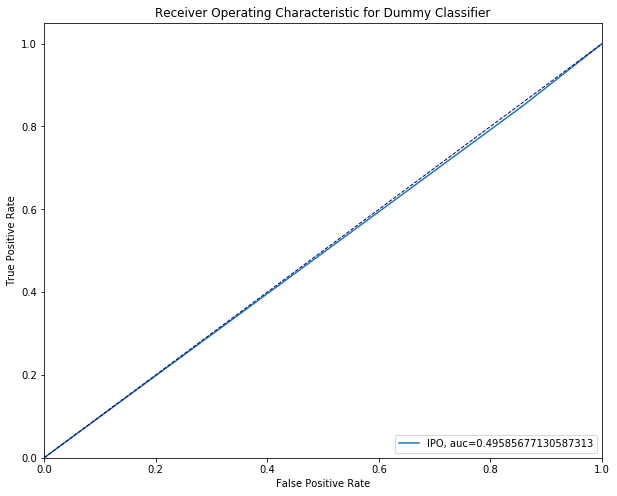

In [80]:
#Proba Prediction
y_pred_proba = dummy_classifier.predict_proba(X_test)[::,1]
y_pred = dummy_classifier.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc_dm = roc_auc_score(y_test, y_pred_proba)

print("Baseline score : "+ str(auc_dm))

#PLOT ROC
lw = 1
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc_dm))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Dummy Classifier')
plt.show()

In [81]:
print('precision: ', precision_score(y_test, y_pred))
print('Recall: ',recall_score(y_test, y_pred))
print('F1_Score: ',f1_score(y_test, y_pred))
print('AUC: ', auc_dm)

precision:  0.8255813953488372
Recall:  0.8502994011976048
F1_Score:  0.8377581120943953
AUC:  0.49585677130587313


## 1. Logistic Regression Model :

In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
# Separate target and features into test and training and validation sets
seed = 1
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

In [84]:
# Remove the ''' to tune the C parameter
estimators = []
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr_clf__penalty='l1')

# Finding best value of C using validation set
scores = []
Cs = []
for C in np.logspace(-4, 5, 10):
    pipeline.set_params(lr_clf__C=C) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    Cs.append(C)

best_C = Cs[scores.index(max(scores))]
print ('best C = %d with auc score = %2.4f' %(best_C, max(scores)))

best C = 10 with auc score = 0.7620


lr classifer auc with l1 regularization = 0.8123
Logistic regression model score : 0.8123147644105726


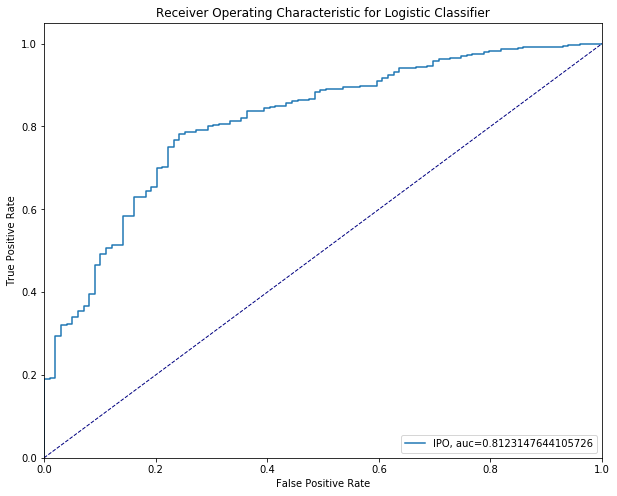

In [85]:
estimators = []
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr_clf__penalty='l1')
pipeline.set_params(lr_clf__C=best_C)
pipeline.fit(X_train,y_train)
y_pred_lr = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_lr[:,1])
print ('lr classifer auc with l1 regularization = %2.4f' %score)

#Proba Prediction
y_pred_proba = y_pred_lr[::,1]
y_pred = pipeline.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc_LR = roc_auc_score(y_test, y_pred_proba)

print("Logistic regression model score : " + str(auc_LR))

#PLOT ROC
lw = 1
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc_LR))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Classifier')
plt.show()

In [86]:
print('precision: ', precision_score(y_test, y_pred))
print('Recall: ',recall_score(y_test, y_pred))
print('F1_Score: ',f1_score(y_test, y_pred))
print('AUC: ', auc_LR)

precision:  0.8773234200743495
Recall:  0.9421157684630739
F1_Score:  0.9085659287776708
AUC:  0.8123147644105726


## 2. Ridge Classifier:

**Model Training:**

In [87]:
seed=0

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('ridge_reg', Ridge()))
ridge_pipe = Pipeline(estimators)
ridge_pipe.set_params(ridge_reg__random_state = seed)

# Fixed parameters
score = 'roc_auc'
n_splits = 3

# CV schema
cv_schema = KFold(n_splits = n_splits, random_state = seed)

# Tune model against a single hyper parameter
tuning_param = 'ridge_reg__alpha'
tuning_param_range = np.logspace(-4, 5, 10)

# Tune hyper parameter using validation curve
train_scores_val, cv_scores_val = validation_curve(
    ridge_pipe, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = score, n_jobs = -1)

# Obtain the best value of the hyper parameter
best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
best_ridge_r2 = max(np.mean(cv_scores_val, axis=1))
print(best_param_val)
print(best_ridge_r2)

0.0001
0.8197592876287755


Ridge regression model score : 0.7931409907457811


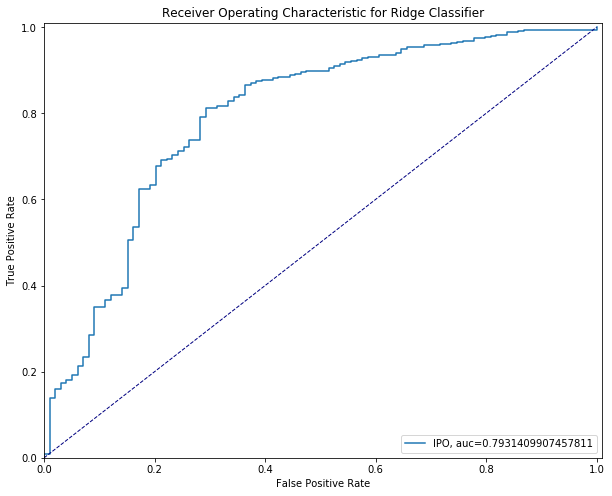

In [88]:
# Set the optimum value for alpha
ridge_pipe.set_params(ridge_reg__alpha = best_param_val)

# Fit the ridge pipe
ridge_pipe.fit(X_train,y_train)

#Proba Prediction
rc_pred = ridge_pipe.predict(X_test)

fpr_rc, tpr_rc, thresholds = roc_curve(y_test, rc_pred)

auc_rc = roc_auc_score(y_test, rc_pred)

print("Ridge regression model score : " + str(auc_rc))

plt.figure(figsize=(10,8))
plt.plot(fpr_rc, tpr_rc, label= 'IPO, auc='+str(auc_rc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Ridge Classifier')
plt.show()

## 3. Gradient boosted trees model :

Function for nested cross-validation, useful for tuning the hyper parameters n_estimators.

In [89]:
def nested_cv(X, y, est_pipe, p_grid, p_score, n_splits_inner = 3, n_splits_outer = 3, n_cores = 1, seed = 0):
    ests = []
    # cross-validation schema for inner and outer loops
    inner_cv = StratifiedKFold(n_splits = n_splits_inner, shuffle = True, random_state = seed)
    outer_cv = StratifiedKFold(n_splits = n_splits_outer, shuffle = True, random_state = seed)

    # grid search to tune hyper parameters
    est = GridSearchCV(estimator = est_pipe, param_grid = p_grid, cv = inner_cv, scoring = p_score, n_jobs = n_cores)
    ests.append(est)
    # nested CV with parameter optimization
    nested_scores = cross_val_score(estimator = est, X = X, y = y, cv = outer_cv, scoring = p_score, n_jobs = n_cores)
    
    print('Average score: %0.4f (+/- %0.4f)' % (nested_scores.mean(), nested_scores.std() * 1.96))
    
    return nested_scores, ests

In [90]:
%%time
seed=0

array = []
array.append(('XGB_clf', XGBClassifier()))
pipe = Pipeline(array)
pipe.set_params(XGB_clf__random_state = seed)

# Possible optimized values 
p_grid = {"XGB_clf__n_estimators": [int(i) for i in np.linspace(10.0, 40.0, 5)]}

nested_scores_xgb, ests_xgb = nested_cv(X = features, y = target, est_pipe = pipe, p_grid = p_grid, p_score = 'accuracy', n_cores = -1)

Average score: 0.8567 (+/- 0.0175)
CPU times: user 20.8 ms, sys: 7.22 ms, total: 28.1 ms
Wall time: 7.05 s


Gradient Boosted trees model score : 0.8006310611101031


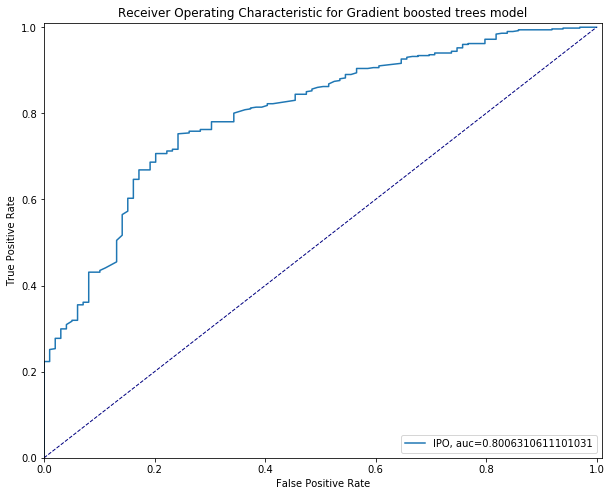

In [91]:
optimal_param = list(p_grid.values())[0][np.argmax(nested_scores_xgb)]
optimal_xgb =  XGBClassifier(n_estimators=optimal_param)
optimal_xgb.fit(X_train,y_train)

xgb_pred = optimal_xgb.predict(X_test)
xgb_prob = optimal_xgb.predict_proba(X_test)[:, 1]

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, xgb_prob)

auc_xgb = roc_auc_score(y_test, xgb_prob)

print("Gradient Boosted trees model score : " + str(auc_xgb))

plt.figure(figsize=(10,8))
plt.plot(fpr_xgb, tpr_xgb, label= 'IPO, auc='+str(auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Gradient boosted trees model')
plt.show()

In [92]:
print('precision: ', precision_score(y_test, xgb_pred))
print('Recall: ',recall_score(y_test, xgb_pred))
print('F1_Score: ',f1_score(y_test, xgb_pred))
print('AUC: ', auc_xgb)

precision:  0.8596802841918295
Recall:  0.9660678642714571
F1_Score:  0.9097744360902256
AUC:  0.8006310611101031


## 4. Random Forest:

**Tuning n_estimators for optimality :**

In [93]:
#Since we have 1839 features, we reduce them using PCA  
'''pca_num = PCA(n_components=50)
pca_num_features = pca_num.fit_transform(features)
num_features = pd.DataFrame(pca_num_features)'''

from sklearn.ensemble import RandomForestClassifier
# Define a random classifier pipeline
estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
pipeline = Pipeline(estimators)
pipeline.set_params(rf_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    pipeline.set_params(rf_clf__n_estimators = NS) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(rf_clf__n_estimators = best_NS)
pipeline.fit(X_train,y_train)
y_pred_rf = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_rf[:,1])
print ('rf classifer auc = %2.4f' %score)

best NS = 90 with auc score = 0.7752
rf classifer auc = 0.7725


Optimal Random Forest model score : 0.7690175205145265


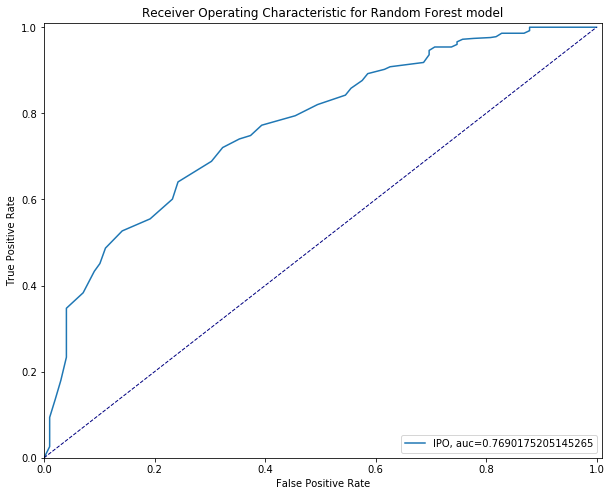

In [94]:
#Model with best n_estimators
RF_reg = RandomForestClassifier(n_estimators=best_NS)
RF_reg.fit(X_train,y_train)

rf_pred = RF_reg.predict(X_test)
rf_prob = RF_reg.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rf_prob)

auc_rf = roc_auc_score(y_test, rf_prob)

print("Optimal Random Forest model score : " + str(auc_rf))

plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, label= 'IPO, auc='+str(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest model')
plt.show()

In [95]:
print('precision: ', precision_score(y_test, rf_pred))
print('Recall: ',recall_score(y_test, rf_pred))
print('F1_Score: ',f1_score(y_test, rf_pred))
print('AUC: ', auc_rf)

precision:  0.8512820512820513
Recall:  0.9940119760479041
F1_Score:  0.9171270718232044
AUC:  0.7690175205145265


## 5. KNN :

In [96]:
# creating odd list of K for KNN
numbers = list(range(1,30))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, numbers))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())


# determining best n
optimal_n = neighbors[np.argmax(cv_scores)]
print("The optimal number of neighbors is %d" % optimal_n)

The optimal number of neighbors is 15


The auc score for KNN : 0.6371701042359724


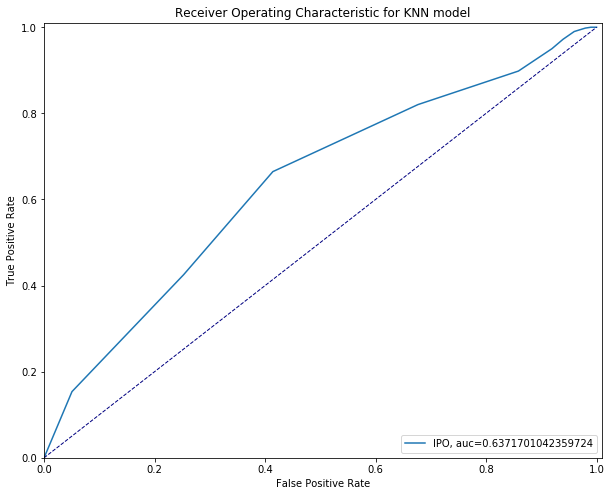

In [97]:
knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train, y_train)
y_prob = knn.predict_proba(X_test)[:, 1]
y_pred = knn.predict(X_test)
auc = roc_auc_score(y_test, y_prob)
print("The auc score for KNN : " + str(auc))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN model')
plt.show()

In [98]:
print('precision: ', precision_score(y_test, y_pred))
print('Recall: ',recall_score(y_test, y_pred))
print('F1_Score: ',f1_score(y_test, y_pred))
print('AUC: ', auc)

precision:  0.8392554991539763
Recall:  0.9900199600798403
F1_Score:  0.9084249084249083
AUC:  0.6371701042359724


## Part 2

Predict whether the closing price is higher than the offering price using __only__ textual field 'Risk_Factors'. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(text-fields) -> Probability of being in class 1 

For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

In [99]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [100]:
#The 'english' stemmer is better than the original 'porter' stemmer.
stemmer = SnowballStemmer('english')
feature = data_encoded.Risk_Factors
stoplist = set(stopwords.words("english"))  

def text_process(text_field):
    lowercase = text_field.lower()
    sentence = re.sub(r"[^a-zA-Z]", " ", lowercase) 
    words = sentence.split()
    no_stop_words = [w for w in words if not w in stoplist]
    stem_words = [stemmer.stem(w) for w in no_stop_words]
    return(" ".join(stem_words))

feature = feature.map(text_process)
feature.head(3)

ID
000307    risk factor invest common stock involv high de...
000833    risk factor invest common stock involv number ...
00086T    risk factor addit inform contain prospectus fo...
Name: Risk_Factors, dtype: object

Converting our preprocessed text into tfidf vectors and considering only the top 500 features ordered by term frequency.

In [101]:
data_encoded['Risk_Factors'] = feature 
vectorizer = TfidfVectorizer(max_features = 500)
risk_factors_trans = vectorizer.fit_transform(feature)
risk_factors_trans = risk_factors_trans.toarray()
risk_factors_trans.shape

(3000, 500)

Projecting our 500 dimensional tfidf vectors into 50 dimensions using PCA. Performing PCA before modeling makes our algorithm run faster, and when performing the model with and without PCA, we saw that we got slightly better results when performing it.

In [102]:
# Standardizing new features before PCA
standardized_features = StandardScaler().fit_transform(risk_factors_trans)
#increasing n_components doesn't heighten necessarily the average score  
pca = PCA(n_components=50)
pca_features = pca.fit_transform(standardized_features)
textual_risk_factors = pd.DataFrame(pca_features)

In [103]:
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(textual_risk_factors, target, test_size = 0.2)

#### Baseline model to compare with our models : Dummy Classifier 

In [104]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train_risk, y_train_risk)
baseline_score = dummy_classifier.score(X_test_risk,y_test_risk)

Baseline score : 0.4697876973326075


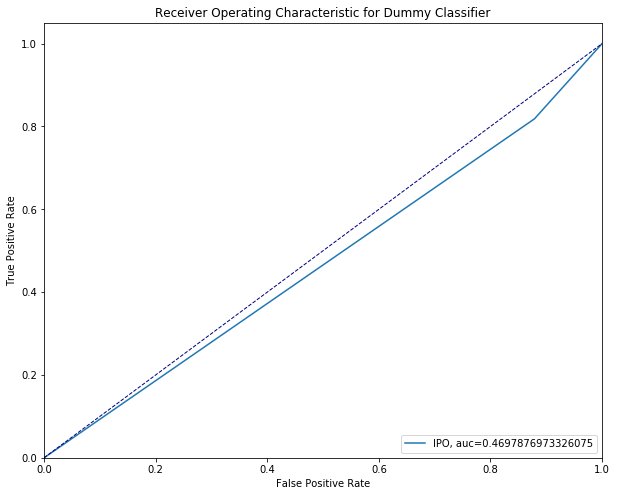

In [105]:
#Proba Prediction
y_pred_proba = dummy_classifier.predict_proba(X_test_risk)[::,1]
y_pred = dummy_classifier.predict(X_test_risk)
fpr, tpr, _ = roc_curve(y_test_risk,  y_pred_proba)
auc_dm = roc_auc_score(y_test_risk, y_pred_proba)

print("Baseline score : "+ str(auc_dm))

#PLOT ROC
lw = 1
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc_dm))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Dummy Classifier')
plt.show()

## 1. Logistic Regression model :

In [106]:
# Separate target and features into test and training and validation sets
seed = 1
X_train_train2, X_train_val2, y_train_train2, y_train_val2 = train_test_split(X_train_risk, y_train_risk, test_size = 0.25, random_state = seed)

In [107]:
# Remove the ''' to tune the C parameter

estimators = []
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr_clf__penalty='l1')

# Finding best value of C using validation set
scores = []
Cs = []
for C in np.logspace(-4, 5, 10):
    pipeline.set_params(lr_clf__C=C) 
    pipeline.fit(X_train_train2,y_train_train2)
    y_train_pred = pipeline.predict_proba(X_train_val2)
    scores.append(roc_auc_score(y_train_val2, y_train_pred[:,1]))
    Cs.append(C)

best_C = Cs[scores.index(max(scores))]
print ('best C = %d with auc score = %2.4f' %(best_C, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(lr_clf__C=best_C)
pipeline.fit(X_train_risk,y_train_risk)
y_pred_lr = pipeline.predict_proba(X_test_risk)
score = roc_auc_score(y_test_risk, y_pred_lr[:,1])
print ('lr classifer auc with l1 regularization = %2.4f' %score)

best C = 1000 with auc score = 0.6081
lr classifer auc with l1 regularization = 0.6173


Logistic regression model score : 0.6172503477892699


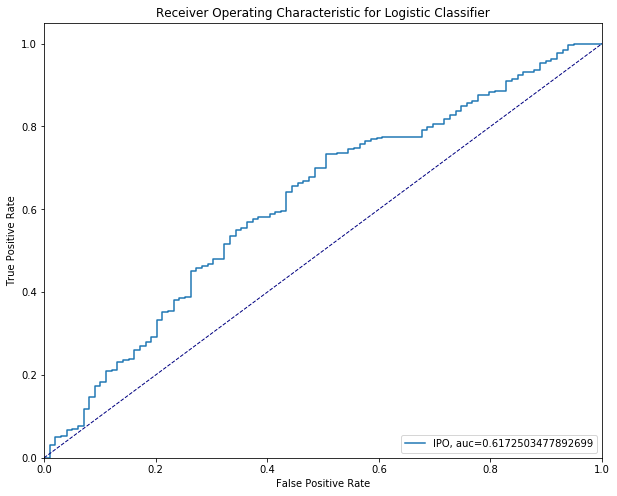

In [108]:
#Proba Prediction
y_pred_proba = y_pred_lr[::,1]
y_pred = pipeline.predict(X_test_risk)
fpr, tpr, _ = roc_curve(y_test_risk,  y_pred_proba)
auc_LR = roc_auc_score(y_test_risk, y_pred_proba)

print("Logistic regression model score : " + str(auc_LR))

#PLOT ROC
lw = 1
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc_LR))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Classifier')
plt.show()

In [109]:
print('precision: ', precision_score(y_test_risk, y_pred))
print('Recall: ',recall_score(y_test_risk, y_pred))
print('F1_Score: ',f1_score(y_test_risk, y_pred))
print('AUC: ', auc_LR)

precision:  0.8421052631578947
Recall:  0.9900199600798403
F1_Score:  0.910091743119266
AUC:  0.6172503477892699


## 2. Ridge Regression model :

In [110]:
seed=0

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('ridge_reg', Ridge()))
ridge_pipe = Pipeline(estimators)
ridge_pipe.set_params(ridge_reg__random_state = seed)

# Fixed parameters
score = 'roc_auc'
n_splits = 3

# CV schema
cv_schema = KFold(n_splits = n_splits, random_state = seed)

# Tune model against a single hyper parameter
tuning_param = 'ridge_reg__alpha'
tuning_param_range = np.logspace(-4, 5, 10)

# Tune hyper parameter using validation curve
train_scores_val, cv_scores_val = validation_curve(
    ridge_pipe, X_train_risk, y_train_risk, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = score, n_jobs = -1)

# Obtain the best value of the hyper parameter
best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
best_ridge_r2 = max(np.mean(cv_scores_val, axis=1))
print(best_param_val)
print(best_ridge_r2)

100000.0
0.6154076037090683


Ridge regression model score : 0.620355249097764


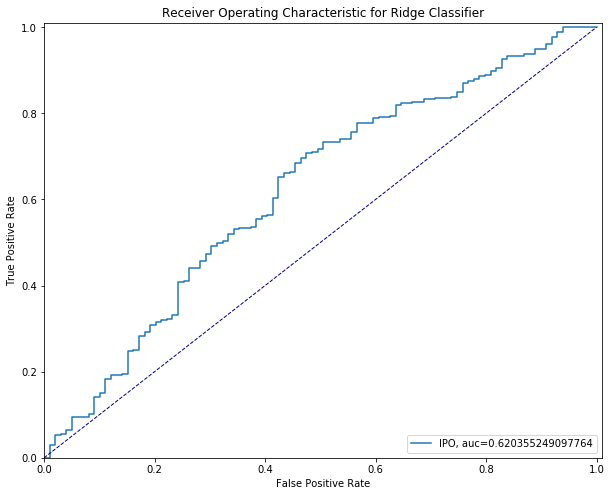

In [111]:
# Set the optimum value for alpha
ridge_pipe.set_params(ridge_reg__alpha = best_param_val)

# Fit the ridge pipe
ridge_pipe.fit(X_train_risk,y_train_risk)

#Proba Prediction
rc_pred = ridge_pipe.predict(X_test_risk)

fpr_rc, tpr_rc, thresholds = roc_curve(y_test_risk, rc_pred)

auc_rc = roc_auc_score(y_test_risk, rc_pred)

print("Ridge regression model score : " + str(auc_rc))

plt.figure(figsize=(10,8))
plt.plot(fpr_rc, tpr_rc, label= 'IPO, auc='+str(auc_rc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Ridge Classifier')
plt.show()

## 3. Gradient boosted trees model :

In [112]:
%%time
seed=0

array1 = []
array1.append(('XGB_clf', XGBClassifier()))
pipe = Pipeline(array1)
pipe.set_params(XGB_clf__random_state = seed)

# Possible optimized values 
p_grid = {"XGB_clf__n_estimators": [int(i) for i in np.linspace(10.0, 40.0, 5)]}

nested_scores_xgb, ests_xgb = nested_cv(X = textual_risk_factors, y = target, est_pipe = pipe, p_grid = p_grid, p_score = 'accuracy', n_cores = -1)

Average score: 0.8403 (+/- 0.0047)
CPU times: user 17 ms, sys: 4.18 ms, total: 21.2 ms
Wall time: 2.76 s


Optimal Gradient Boosted trees model score : 0.6367164660577834


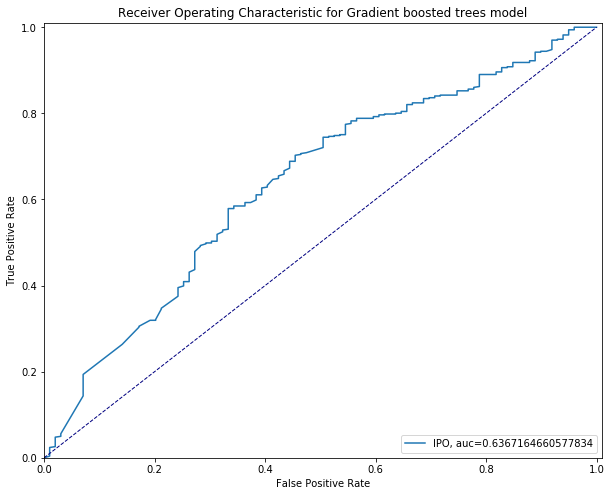

In [113]:
optimal_param = list(p_grid.values())[0][np.argmax(nested_scores_xgb)]
optimal_xgb =  XGBClassifier(n_estimators=optimal_param)
optimal_xgb.fit(X_train_risk,y_train_risk)

xgb_pred = optimal_xgb.predict(X_test_risk)
xgb_prob = optimal_xgb.predict_proba(X_test_risk)[:, 1]

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test_risk, xgb_prob)

auc_xgb = roc_auc_score(y_test_risk, xgb_prob)

print("Optimal Gradient Boosted trees model score : " + str(auc_xgb))

plt.figure(figsize=(10,8))
plt.plot(fpr_xgb, tpr_xgb, label= 'IPO, auc='+str(auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Gradient boosted trees model')
plt.show()

In [114]:
print('precision: ', precision_score(y_test_risk, xgb_pred))
print('Recall: ',recall_score(y_test_risk, xgb_pred))
print('F1_Score: ',f1_score(y_test_risk, xgb_pred))
print('AUC: ', auc_xgb)

precision:  0.8391959798994975
Recall:  1.0
F1_Score:  0.912568306010929
AUC:  0.6367164660577834


## 4. Random forest model : 

In [115]:
%%time

array1 = []
array1.append(('rf_clf', RandomForestClassifier()))
pipe = Pipeline(array1)
pipe.set_params(rf_clf__random_state = seed)

# Possible optimized values 
p_grid = {"rf_clf__n_estimators": [50, 100, 120, 150, 200]}

nested_scores_rf, ests_rf = nested_cv(X = textual_risk_factors, y = target, est_pipe = pipe, p_grid = p_grid, p_score = 'accuracy', n_cores = -1)

Average score: 0.8420 (+/- 0.0029)
CPU times: user 18.5 ms, sys: 4.91 ms, total: 23.4 ms
Wall time: 16.6 s


120
Optimal Random Forest model score : 0.620103227887659


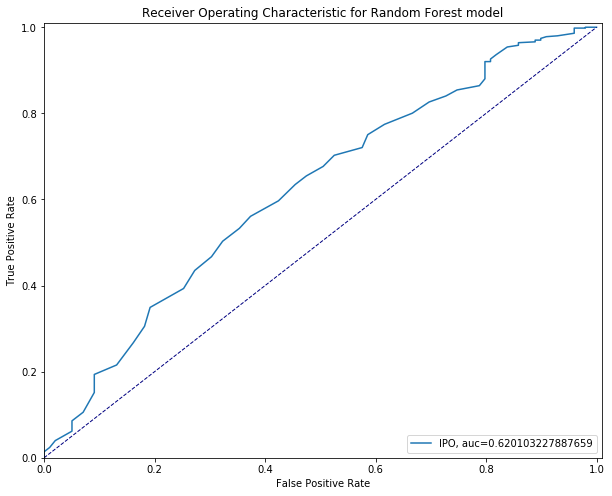

In [116]:
optimal_param_rf = list(p_grid.values())[0][np.argmax(nested_scores_rf)]
print(optimal_param_rf)
optimal_rf =  RandomForestClassifier(n_estimators=optimal_param_rf)
optimal_rf.fit(X_train_risk,y_train_risk)

rf_pred = optimal_rf.predict(X_test_risk)
rf_prob = optimal_rf.predict_proba(X_test_risk)[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test_risk, rf_prob)

auc_rf = roc_auc_score(y_test_risk, rf_prob)

print("Optimal Random Forest model score : " + str(auc_rf))

plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, label= 'IPO, auc='+str(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest model')
plt.show()

In [117]:
print('precision: ', precision_score(y_test_risk, rf_pred))
print('Recall: ',recall_score(y_test_risk, rf_pred))
print('F1_Score: ',f1_score(y_test_risk, rf_pred))
print('AUC: ', auc_rf)

precision:  0.8400673400673401
Recall:  0.9960079840319361
F1_Score:  0.9114155251141552
AUC:  0.620103227887659


## 5.  KNN Classifier :

In [118]:
# creating odd list of K for KNN
numbers = list(range(1,30))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, numbers))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train_risk, y_train_risk, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


# determining best n
optimal_n = neighbors[np.argmax(cv_scores)]
print("The optimal number of neighbors is %d" % optimal_n)

The optimal number of neighbors is 21


The auc score for KNN is : 0.6332688159035466


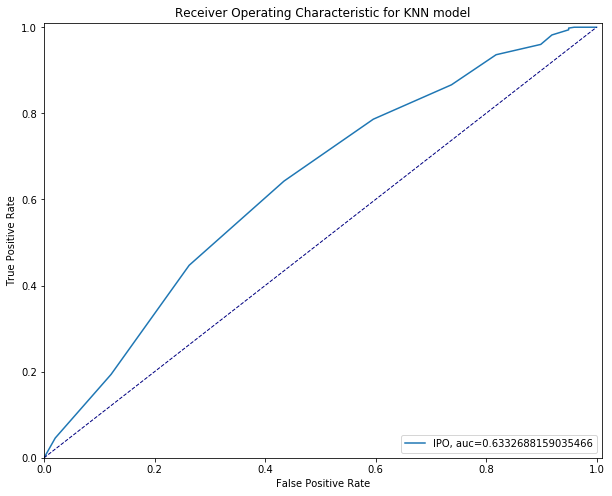

In [119]:
knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train_risk, y_train_risk)
y_prob = knn.predict_proba(X_test_risk)[:, 1]
y_pred = knn.predict(X_test_risk)
fpr, tpr, thresholds = roc_curve(y_test_risk, y_prob)
auc = roc_auc_score(y_test_risk, y_prob)
print("The auc score for KNN is : " + str(auc))
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN model')
plt.show()

In [120]:
print('precision: ', precision_score(y_test_risk, y_pred))
print('Recall: ',recall_score(y_test_risk, y_pred))
print('F1_Score: ',f1_score(y_test_risk, y_pred))
print('AUC: ', auc)

precision:  0.8417508417508418
Recall:  0.998003992015968
F1_Score:  0.9132420091324202
AUC:  0.6332688159035466


## Part 3

Predict whether the closing price is higher than the offering price using __all__ fields. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(all-fields) -> Probability of being in class 1 
    
For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

In [121]:
non_textual_features = features
all_features = pd.merge(non_textual_features.reset_index(), textual_risk_factors, left_index=True, right_index= True).set_index('ID') 
all_features.dtypes.unique()
all_features.head(2)

,Offering_Price,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,pctchg_sp_2,pctchg_dj_2,...,40,41,42,43,44,45,46,47,48,49
ID,,,,,,,,,,,,,,,,,,,,,
000307,0.157239,-0.394671,-0.936067,0.18313,-0.130053,0.028997,-0.878425,-1.363798,-1.245182,-0.492059,...,-0.124960,1.913146,0.929874,1.397083,-0.144351,0.192635,-3.019099,-2.242592,-0.777999,1.240370
000833,-0.161266,-0.394671,-0.369156,0.18313,-0.130053,0.028997,-0.161225,-0.400945,-0.489266,-1.377844,...,-1.167919,0.754873,0.287343,-2.780408,0.498412,1.591616,-0.842809,-0.582572,0.173571,-1.401449


In [122]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_features, target, test_size = 0.2)

In [123]:
all_features.shape

(3000, 221)

### Baseline Model to compare with our models :

In [124]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train_all, y_train_all)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

Baseline score : 0.49577905158936947


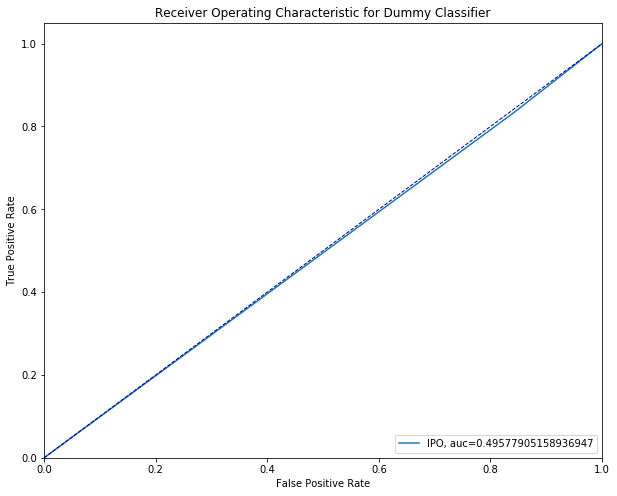

In [125]:
#Proba Prediction
y_pred_proba = dummy_classifier.predict_proba(X_test_all)[::,1]
y_pred = dummy_classifier.predict(X_test_all)
fpr, tpr, _ = roc_curve(y_test_all,  y_pred_proba)
auc_dm = roc_auc_score(y_test_all, y_pred_proba)

print("Baseline score : "+ str(auc_dm))

#PLOT ROC
lw = 1
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc_dm))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Dummy Classifier')
plt.show()

## 1. Logistic Regression model :

In [126]:
# Separate target and features into test and training and validation sets
seed = 1
X_train_train3, X_train_val3, y_train_train3, y_train_val3 = train_test_split(X_train_all, y_train_all, test_size = 0.25, random_state = seed)

In [127]:
# Remove the ''' to tune the C parameter

estimators = []
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr_clf__penalty='l1')

# Finding best value of C using validation set
scores = []
Cs = []
for C in np.logspace(-4, 5, 5):
    pipeline.set_params(lr_clf__C=C) 
    pipeline.fit(X_train_train3,y_train_train3)
    y_train_pred = pipeline.predict_proba(X_train_val3)
    scores.append(roc_auc_score(y_train_val3, y_train_pred[:,1]))
    Cs.append(C)

best_C = Cs[scores.index(max(scores))]
print ('best C = %d with auc score = %2.4f' %(best_C, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(lr_clf__C=best_C)
pipeline.fit(X_train_all,y_train_all)
y_pred_lr = pipeline.predict_proba(X_test_all)
score = roc_auc_score(y_test_all, y_pred_lr[:,1])
print ('lr classifer auc with l1 regularization = %2.4f' %score)

best C = 3 with auc score = 0.7631
lr classifer auc with l1 regularization = 0.8253


Logistic regression model score : 0.8252631578947368


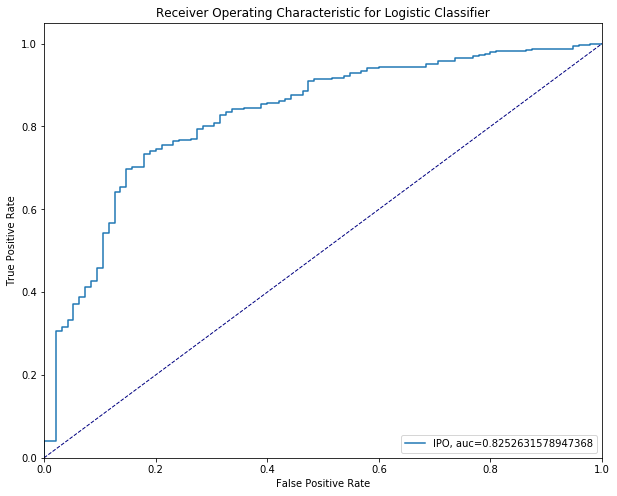

In [128]:
#Proba Prediction
y_pred_proba = y_pred_lr[::,1]
y_pred = pipeline.predict(X_test_all)
fpr, tpr, _ = roc_curve(y_test_all,  y_pred_proba)
auc_LR = roc_auc_score(y_test_all, y_pred_proba)

print("Logistic regression model score : " + str(auc_LR))

#PLOT ROC
lw = 1
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc_LR))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Classifier')
plt.show()

In [129]:
print('precision: ', precision_score(y_test_all, y_pred))
print('Recall: ',recall_score(y_test_all, y_pred))
print('F1_Score: ',f1_score(y_test_all, y_pred))
print('AUC: ', auc_LR)

precision:  0.8880597014925373
Recall:  0.9425742574257425
F1_Score:  0.914505283381364
AUC:  0.8252631578947368


## 2. Ridge Regression model :

In [130]:
seed=0

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('ridge_reg', Ridge()))
ridge_pipe = Pipeline(estimators)
ridge_pipe.set_params(ridge_reg__random_state = seed)

# Fixed parameters
score = 'roc_auc'
n_splits = 3

# CV schema
cv_schema = KFold(n_splits = n_splits, random_state = seed)

# Tune model against a single hyper parameter
tuning_param = 'ridge_reg__alpha'
tuning_param_range = np.logspace(-4, 5, 10)

# Tune hyper parameter using validation curve
train_scores_val, cv_scores_val = validation_curve(
    ridge_pipe, X_train_all, y_train_all, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = score, n_jobs = -1)

# Obtain the best value of the hyper parameter
best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
best_ridge_r2 = max(np.mean(cv_scores_val, axis=1))
print(best_param_val)
print(best_ridge_r2)

0.01
0.8010728730678203


Ridge regression model score : 0.8458989056800417


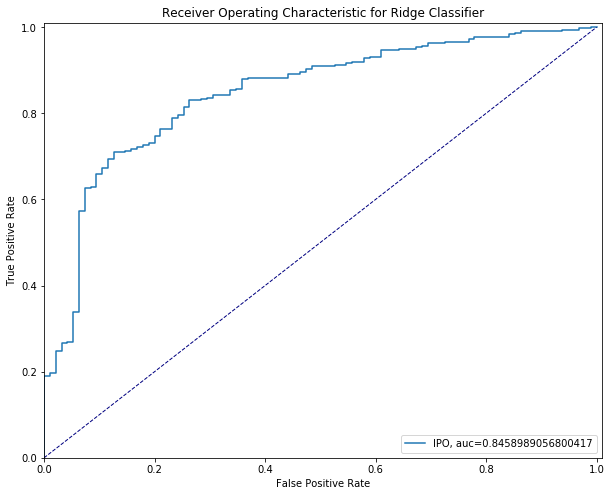

In [131]:
# Set the optimum value for alpha
ridge_pipe.set_params(ridge_reg__alpha = best_param_val)

# Fit the ridge pipe
ridge_pipe.fit(X_train_all,y_train_all)

#Proba Prediction
rc_pred = ridge_pipe.predict(X_test_all)

fpr_rc, tpr_rc, thresholds = roc_curve(y_test_all, rc_pred)

auc_rc = roc_auc_score(y_test_all, rc_pred)

print("Ridge regression model score : " + str(auc_rc))

plt.figure(figsize=(10,8))
plt.plot(fpr_rc, tpr_rc, label= 'IPO, auc='+str(auc_rc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Ridge Classifier')
plt.show()

## 3. Gradient boosted trees model :

In [132]:
%%time
seed=0

array1 = []
array1.append(('XGB_clf', XGBClassifier()))
pipe = Pipeline(array1)
pipe.set_params(XGB_clf__random_state = seed)

# Possible optimized values 
p_grid = {"XGB_clf__n_estimators": [int(i) for i in np.linspace(10.0, 80.0, 5)]}

nested_scores_all_xgb, ests_all_xgb = nested_cv(X = all_features, y = target, est_pipe = pipe, p_grid = p_grid, p_score = 'accuracy', n_cores = -1)

Average score: 0.8567 (+/- 0.0258)
CPU times: user 21.2 ms, sys: 7.26 ms, total: 28.5 ms
Wall time: 16.4 s


Optimal Gradient Boosted trees model score : 0.8478374153204793


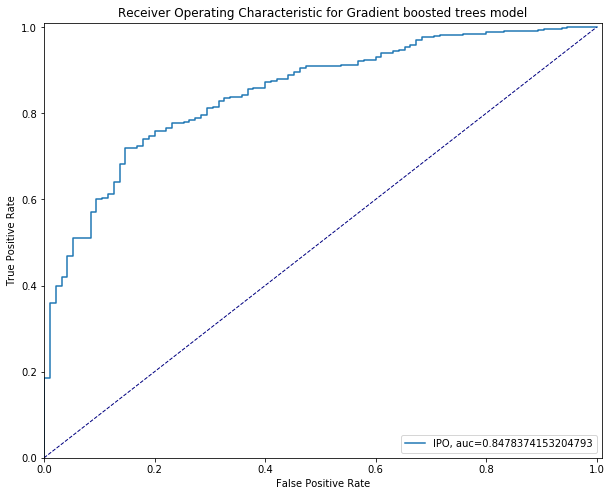

In [133]:
optimal_param = list(p_grid.values())[0][np.argmax(nested_scores_all_xgb)]
optimal_all_xgb =  XGBClassifier(n_estimators=optimal_param)
optimal_all_xgb.fit(X_train_all,y_train_all)

xgb_pred = optimal_all_xgb.predict(X_test_all)
xgb_prob = optimal_all_xgb.predict_proba(X_test_all)[:, 1]

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test_all, xgb_prob)

auc_xgb = roc_auc_score(y_test_all, xgb_prob)

print("Optimal Gradient Boosted trees model score : " + str(auc_xgb))

plt.figure(figsize=(10,8))
plt.plot(fpr_xgb, tpr_xgb, label= 'IPO, auc='+str(auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Gradient boosted trees model')
plt.show()

In [134]:
print('precision: ', precision_score(y_test_all, xgb_pred))
print('Recall: ',recall_score(y_test_all, xgb_pred))
print('F1_Score: ',f1_score(y_test_all, xgb_pred))
print('AUC: ', auc_xgb)

precision:  0.8704028021015762
Recall:  0.9841584158415841
F1_Score:  0.9237918215613382
AUC:  0.8478374153204793


## 4. Random forest model : 

In [135]:
%%time

array1 = []
array1.append(('rf_clf', RandomForestClassifier()))
pipe = Pipeline(array1)
pipe.set_params(rf_clf__random_state = seed)

# Possible optimized values 
p_grid = {"rf_clf__n_estimators": [50, 100, 120, 150, 200]}

nested_scores_all_rf, ests_all_rf = nested_cv(X = all_features, y = target, est_pipe = pipe, p_grid = p_grid, p_score = 'accuracy', n_cores = -1)

Average score: 0.8477 (+/- 0.0080)
CPU times: user 22.8 ms, sys: 7.04 ms, total: 29.8 ms
Wall time: 17.7 s


100
Optimal Random Forest model score : 0.8113913496612819


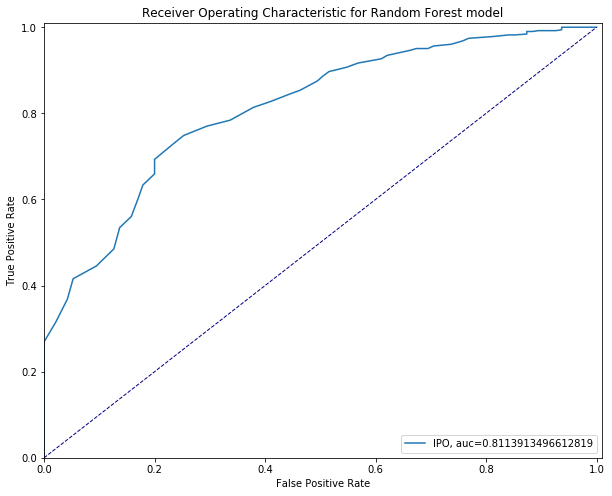

In [136]:
optimal_param_rf = list(p_grid.values())[0][np.argmax(nested_scores_all_rf)]
print(optimal_param_rf)
optimal_all_rf =  RandomForestClassifier(n_estimators=optimal_param_rf)
optimal_all_rf.fit(X_train_all,y_train_all)

rf_pred = optimal_all_rf.predict(X_test_all)
rf_prob = optimal_all_rf.predict_proba(X_test_all)[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test_all, rf_prob)

auc_rf = roc_auc_score(y_test_all, rf_prob)

print("Optimal Random Forest model score : " + str(auc_rf))

plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, label= 'IPO, auc='+str(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest model')
plt.show()

In [137]:
print('precision: ', precision_score(y_test_all, rf_pred))
print('Recall: ',recall_score(y_test_all, rf_pred))
print('F1_Score: ',f1_score(y_test_all, rf_pred))
print('AUC: ', auc_rf)

precision:  0.8505942275042445
Recall:  0.9920792079207921
F1_Score:  0.9159049360146253
AUC:  0.8113913496612819


## 5. KNN Classifier :

In [138]:
# creating odd list of K for KNN
numbers = list(range(1,30))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, numbers))

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train_all, y_train_all, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())


# determining best n
optimal_n = neighbors[np.argmax(cv_scores)]
print("The optimal number of neighbors is %d" % optimal_n)

The optimal number of neighbors is 9


The final auc score for KNN : 0.5924960917144345


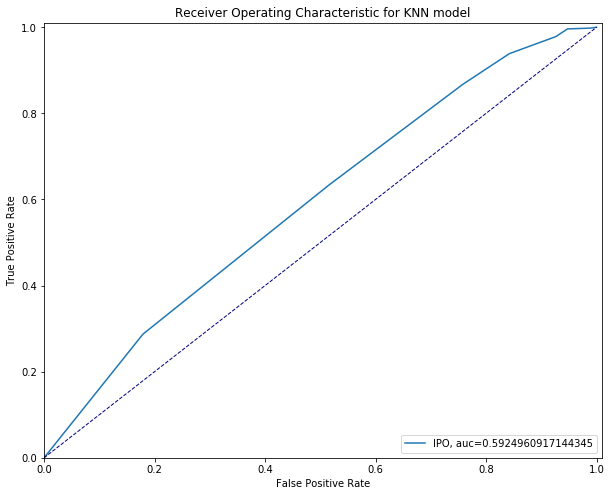

In [139]:
knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train_all, y_train_all)
y_prob = knn.predict_proba(X_test_all)[:, 1]
y_pred = knn.predict(X_test_all)

fpr, tpr, thresholds = roc_curve(y_test_all, y_prob)
auc = roc_auc_score(y_test_all, y_prob)

print("The final auc score for KNN : " + str(auc))

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label= 'IPO, auc='+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN model')
plt.show()

In [140]:
print('precision: ', precision_score(y_test_all, y_pred))
print('Recall: ',recall_score(y_test_all, y_pred))
print('F1_Score: ',f1_score(y_test_all, y_pred))
print('AUC: ', auc)

precision:  0.8487972508591065
Recall:  0.9782178217821782
F1_Score:  0.9089236430542778
AUC:  0.5924960917144345


## Part 4
  
Predict the share price at the end of the day using __all__ fields.

    f(all-fields) ->  Share price at the end of the first day of trading
    
For the evaluation metric, report statisitcs for R-squared, Residual Mean Squared Error, Mean Absolute Error, and Median Absolute Error; however, be sure to tune and hypertune your models using R-Squared.

**In this part, our target is the Closing_Price.**

In [141]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn import metrics

In [142]:
share_price = data_encoded.Closing_Price
share_price.head(2)

ID
000307    18.50
000833    12.85
Name: Closing_Price, dtype: float64

In [143]:
share_price.nunique()

1295

**Our Target data, i.e the share price at the end of the day, is continuous. Hence, we will only consider models that accept a continuous target as input.**

In [144]:
X_train_all2, X_test_all2, y_train_all2, y_test_all2 = train_test_split(all_features, share_price, test_size = 0.2)

### Baseline Model to compare with our models :

In [145]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train_all2, y_train_all2)
y_pred = dummy_classifier.predict(X_test_all2)
r2 = metrics.r2_score(y_test_all2, y_pred)
mean_sqr_error = mean_squared_error(y_test_all2, y_pred)
mean_abs_error = mean_absolute_error(y_test_all2, y_pred)
median_abs_error = median_absolute_error(y_test_all2, y_pred)
print("Baseline R-squared score : " + str(r2))
print("Baseline Mean Squared Error : " + str(mean_sqr_error))
print("Baseline Mean Absolute Error : "+ str(mean_abs_error))
print("Baseline Median Absolute Error : "+ str(median_abs_error))

Baseline R-squared score : -1.7353227506165774
Baseline Mean Squared Error : 433.0887251139585
Baseline Median Absolute Error : 11.59266875
Baseline Median Absolute Error : 7.125


In [146]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

## 1. Ridge Regression Model : 

After trying, we had better results when scaling, so we scale for Ridge and Lasso :

In [147]:
seed=0

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('ridge_reg', Ridge()))
ridge_pipe = Pipeline(estimators)
ridge_pipe.set_params(ridge_reg__random_state = seed)

# Fixed parameters
score = 'r2'
n_splits = 3

# CV schema
cv_schema = KFold(n_splits = n_splits, random_state = seed)

# Tune model against a single hyper parameter
tuning_param = 'ridge_reg__alpha'
tuning_param_range = np.logspace(-4, 5, 10)

# Tune hyper parameter using validation curve
train_scores_val, cv_scores_val = validation_curve(
    ridge_pipe, X_train_all2, y_train_all2, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = score, n_jobs = -1)

# Obtain the best value of the hyper parameter
best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
best_ridge_r2 = max(np.mean(cv_scores_val, axis=1))
print(best_param_val)
print(best_ridge_r2)

1000.0
0.6059395969760991


In [148]:
# Set the optimum value for alpha
ridge_pipe.set_params(ridge_reg__alpha = best_param_val)

# Fit the ridge pipe
ridge_pipe.fit(X_train_all2,y_train_all2)

y_pred_ridge = ridge_pipe.predict(X_test_all2)

r2 = metrics.r2_score(y_test_all2, y_pred_ridge)
mean_sqr_error = mean_squared_error(y_test_all2, y_pred_ridge)
mean_abs_error = mean_absolute_error(y_test_all2, y_pred_ridge)
median_abs_error = median_absolute_error(y_test_all2, y_pred_ridge)
print("Ridge R-squared score : " + str(r2))
print("Ridge Mean Squared Error : " + str(mean_sqr_error))
print("Ridge Mean Absolute Error : "+ str(mean_abs_error))
print("Ridge Median Absolute Error : "+ str(median_abs_error))

Ridge R-squared score : 0.6609154199462648
Ridge Mean Squared Error : 53.68789055996096
Ridge Median Absolute Error : 4.291796155621481
Ridge Median Absolute Error : 2.910876605008215


## 2. Lasso Regression Model : 

In [149]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lasso_reg', Lasso()))
lasso_pipe = Pipeline(estimators)
lasso_pipe.set_params(lasso_reg__random_state = seed)

# Fixed parameters
score = 'r2'
n_splits = 3

# CV schema
cv_schema = KFold(n_splits = n_splits, random_state = seed)

# Tune model against a single hyper parameter
tuning_param = 'lasso_reg__alpha'
tuning_param_range = np.logspace(-5, 3, 10)

# Tune hyper parameter using validation curve
from sklearn.model_selection import validation_curve
train_scores_val, cv_scores_val = validation_curve(
    lasso_pipe, X_train_all2, y_train_all2, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = score, n_jobs = -1)

# Obtain the best value of the hyper parameter

best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
best_ridge_r2 = max(np.mean(cv_scores_val, axis=1))
print(best_param_val)
print(best_ridge_r2)

0.2782559402207126
0.6310103970576201


In [150]:
# Set the optimum value for alpha
lasso_pipe.set_params(lasso_reg__alpha = best_param_val)

# Fit the lasso pipe
lasso_pipe.fit(X_train_all2,y_train_all2)

y_pred_lasso = lasso_pipe.predict(X_test_all2)

r2 = metrics.r2_score(y_test_all2, y_pred_lasso)
mean_sqr_error = mean_squared_error(y_test_all2, y_pred_lasso)
mean_abs_error = mean_absolute_error(y_test_all2, y_pred_lasso)
median_abs_error = median_absolute_error(y_test_all2, y_pred_lasso)
print("Lasso Regression R-squared score : " + str(r2))
print("Lasso Regression Mean Squared Error : " + str(mean_sqr_error))
print("Lasso Regression Mean Absolute Error : "+ str(mean_abs_error))
print("Lasso Regression Median Absolute Error : "+ str(median_abs_error))

Lasso Regression R-squared score : 0.6732895625648476
Lasso Regression Mean Squared Error : 51.72866960519344
Lasso Regression Median Absolute Error : 4.430382804120622
Lasso Regression Median Absolute Error : 3.1130585916044478


## 3. Gradient Boosted Trees Model :

In [151]:
estimators = []
estimators.append(('gb_reg', GradientBoostingRegressor()))
gb_pipe = Pipeline(estimators)
gb_pipe.set_params(gb_reg__random_state = seed)

# Fixed parameters
score = 'r2'
n_splits = 3

# CV schema
cv_schema = KFold(n_splits = n_splits, random_state = seed)

# Tune model against a single hyper parameter
tuning_param = 'gb_reg__n_estimators'
tuning_param_range = [int(i) for i in np.linspace(10.0, 50.0, 5)]

# Tune hyper parameter using validation curve
train_scores_val, cv_scores_val = validation_curve(
    gb_pipe, X_train_all2, y_train_all2, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = score, n_jobs = -1)

# Obtain the best value of the hyper parameter
best_param_val = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
best_ridge_r2 = max(np.mean(cv_scores_val, axis=1))
print(best_param_val)
print(best_ridge_r2)

50
0.679122550333101


In [152]:
# Set the optimum value for n_estimators
gb_pipe.set_params(gb_reg__n_estimators = best_param_val)

# Fit the lasso pipe
gb_pipe.fit(X_train_all2,y_train_all2)

y_pred_gb = gb_pipe.predict(X_test_all2)

r2 = metrics.r2_score(y_test_all2, y_pred_gb)
mean_sqr_error = mean_squared_error(y_test_all2, y_pred_gb)
mean_abs_error = mean_absolute_error(y_test_all2, y_pred_gb)
median_abs_error = median_absolute_error(y_test_all2, y_pred_gb)
print("Gradient Boosted Trees R-squared score : " + str(r2))
print("Gradient Boosted Trees Mean Squared Error : " + str(mean_sqr_error))
print("Gradient Boosted Trees Mean Absolute Error : "+ str(mean_abs_error))
print("Gradient Boosted Trees Median Absolute Error : "+ str(median_abs_error))

Gradient Boosted Trees R-squared score : 0.7398469541051343
Gradient Boosted Trees Mean Squared Error : 41.19051433902027
Gradient Boosted Trees Median Absolute Error : 3.156072414476652
Gradient Boosted Trees Median Absolute Error : 1.492046038528028


# Predicting the targets of parts 1-4 using the best model in every part and writing everything in the excel file : 

## Preprocessing again the features :

In [153]:
raw_test_data = pd.read_excel('ipo_to_predict.xlsx')
print(raw_test_data.shape)
raw_test_data.set_index('ID', drop = True, inplace = True)
raw_test_data.head(2)

(474, 158)


,Offering_Price,Risk_Factors,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,pctchg_sp_2,...,avg_firm_amt_vexp,max_firm_amt_vexp,min_fund_amt_vexp,max_fund_amt_vexp,Num_Shares,Price_Change_Non_Textual,Price_Change_Textual,Price_Change_All,Price_All,Your_Bet
ID,,,,,,,,,,,,,,,,,,,,,
8A8021,12.0,risk factors any investment in our securities ...,Comb.,0.88,0.0,0.0,0.0,0.73,0.53,1.25,...,NaN,NaN,NaN,NaN,8125000,NaN,NaN,NaN,NaN,NaN
8A8311,11.0,RISK FACTORS _An investment in our ordinary sh...,Comb.,-1.50,0.0,0.0,0.0,0.84,-0.83,-0.58,...,NaN,NaN,NaN,NaN,14229999,NaN,NaN,NaN,NaN,NaN


In [154]:
#Dropping columns dropped previously with 50% missing data
reduced_features_data2 = raw_test_data.drop(columns=['bvps_bef_offer', 'int_aft', 'int_bef', 'intern)shs', 'pb_value',
       'pct_int_shs'])
reduced_features_data2.shape

(474, 151)

In [155]:
#Mapping of non-numerical Features
non_numerical = reduced_features_data2.select_dtypes(include = ['object']).columns
#Mapping of numerical Features
numerical = reduced_features_data2.select_dtypes(exclude = 'object')
numerical = numerical.select_dtypes(exclude = 'datetime64')
categ_feat_todrop = ['zip', 'nation', 'city', 'ind_group', 'prim_naic','naic_primary', 'amd_date', 'sic_main', 'naic_decr', 'ht_ind_gr', 'ht_ind', 'industry','issuer', 'mgrs', 'uop', 'veic_descr', 'mgrs_role', 'legal']
encoding_data = reduced_features_data2.drop(columns = categ_feat_todrop)

In [156]:
encoding_data['exch'] = encoding_data['exch'].replace({'Sm Cap Mkt' : 'smcap',
                              'Sm Cap Mkt\nBoston' : 'smcap',
                             'NYSE MKT' : 'New York',
                             'NYSE Amex' : 'New York',
                             'Nasdaq\nPacific' : 'Nasdaq',
                             'NYSE Arca' : 'New York',
                             'Nasdaq\nBoston' : 'New York',
                             'New York\nToronto' : 'New York',
                             'OTC\nNasdaq' : 'OTC',
                             'NYSE Alter' : 'New York',
                             'American\nToronto' : 'OTC',
                             'Nasdaq\nToronto' : 'OTC',
                             'Sm Cap Mkt\nChicago' : 'smcap',
                             'New York\nFrankfurt' : 'dax',
                             'Boston\nSm Cap Mkt' : 'smcap',
                             'Pacific\nSm Cap Mkt\nOTC' : 'OTC',
                             'Nasdaq\nNew York' : 'Nasdaq',
                             'OTC\nAmerican' : 'OTC'})
lab_enc = LabelEncoder()
exch_encoded = lab_enc.fit_transform(encoding_data.exch)
encoding_data['exch']=exch_encoded

In [157]:
encoding_data['lockup_days'] = encoding_data['lockup_days'].str[:3].replace({'90\n':'90', '60\n':'60', '45\n':'45',
                                             '87/n':'87', '\n\n':'0', '\n90':'90',
                                             '91\n':'91', '80\n':'80','87\n':'80', '15\n':'15'})
#lockup_days feature is type int, so it is replaced that way :
encoding_data['lockup_days'] = encoding_data['lockup_days'].fillna('0')
encoding_data['lockup_days'] = encoding_data['lockup_days'].astype(int)
encoding_data['lockup_days'] = encoding_data['lockup_days'].replace({0:encoding_data['lockup_days'].mean()})

In [158]:
num_vexp = ['min_round_vexp','avg_round_vexp', 'max_round_vexp', 'min_firm_amt_vexp', 'avg_firm_amt_vexp', 'max_firm_amt_vexp','min_fund_amt_vexp', 'max_fund_amt_vexp' ]

#removing the quotes from the vexp features to convert them to float     
for feature in num_vexp:
    encoding_data[feature] = encoding_data[feature].str.replace("\'", '')
    encoding_data[feature] = encoding_data[feature].astype(np.float64)
    
#Add the previous features to numerical features:
numerical = encoding_data.select_dtypes(exclude='object')

encoding_data = encoding_data.drop(columns = ['offer_date', 'lockup_date', 'all_sic'])

In [159]:
encoding_data['mgt_fee'] = encoding_data['mgt_fee'].replace({'Comb.':'0'})
encoding_data['mgt_fee'] = encoding_data['mgt_fee'].astype(float)
mgt_med = encoding_data['mgt_fee'].median()
encoding_data['mgt_fee'] = encoding_data['mgt_fee'].replace({0:mgt_med})

In [160]:
#The missing values are filled by other for ease
encoding_data['auditor'] = encoding_data['auditor'].fillna('other')

In [161]:
str_replace(encoding_data,'auditor', 'KPMG', 'KPMG')
str_replace(encoding_data,'auditor', 'Ernst', 'EY')
str_replace(encoding_data,'auditor', 'Pricewaterhouse', 'PWC')
str_replace(encoding_data,'auditor', 'Price', 'PWC')
str_replace(encoding_data,'auditor', 'Deloitte', 'Deloitte')
str_replace(encoding_data,'auditor', 'Arthur', 'AACo')
str_replace(encoding_data,'auditor', 'Coopers', 'CL')
str_replace(encoding_data,'auditor', 'Grant', 'GTL')
str_replace(encoding_data,'auditor', 'BDO', 'BDO')
str_replace(encoding_data,'auditor', 'McGladrey', 'MP')
str_replace(encoding_data,'auditor', 'Crowe', 'CCo')
str_replace(encoding_data,'auditor', 'Ernst & Young LLP', 'EY')

In [162]:
top_audit = ['KPMG', 'EY', 'PWC', 'Deloitte', 'AACo', 'CL', 'GTL', 'BDO', 'MP', 'CCO']
str_remain_other(encoding_data,'auditor', top_audit)
encoding_data['auditor'].value_counts()

PWC         104
EY          103
KPMG         81
Deloitte     69
Other        51
AACo         42
GTL          11
MP            6
BDO           5
CL            2
Name: auditor, dtype: int64

In [163]:
lab_enc2 = LabelEncoder()
auditor_encoded = lab_enc2.fit_transform(encoding_data.auditor)
encoding_data['auditor']=auditor_encoded

In [164]:
#Book Runner Treatment:
str_replace(encoding_data,'br', 'Goldman', 'GMS')
str_replace(encoding_data,'br', 'Merril', 'ML')
str_replace(encoding_data,'br', 'First', 'FBC')
str_replace(encoding_data,'br', 'Morgan Stanley', 'MS')
str_replace(encoding_data,'br', 'Lehman', 'LB')
str_replace(encoding_data,'br', 'Donaldson', 'DLJ')
str_replace(encoding_data,'br', 'Hambrecht', 'Hbr')
str_replace(encoding_data,'br', 'BancBoston', 'BS')
str_replace(encoding_data,'br', 'JP', 'JPM')
str_replace(encoding_data,'br', 'Salomon', 'slm')
str_replace(encoding_data,'br', 'Alex', 'Alb')
str_replace(encoding_data,'br', 'Montgomery', 'MgtS')
str_replace(encoding_data,'br', 'Cowen', 'CSC')
str_replace(encoding_data,'br', 'Credit Suisse', 'CrS')
str_replace(encoding_data,'br', 'Deuthsche', 'DBSc')
str_replace(encoding_data,'br', 'Robertson', 'RbS')
str_replace(encoding_data,'br', 'America', 'AmB')
str_replace(encoding_data,'br', 'Chase', 'chse')

In [165]:
num_br = encoding_data.br.value_counts()
br_loc = encoding_data.br.isin(num_br.index[num_br < 22])
encoding_data.loc[br_loc, 'br'] = 'Other'

In [166]:
lab_enc3 = LabelEncoder()
br_encoded = lab_enc3.fit_transform(encoding_data.br)
encoding_data['br']=br_encoded

In [167]:
for i in range (0, encoding_data.shape[0]):
    encoding_data['description'][i] = re.sub("\D","",encoding_data['description'][i])
encoding_data['description'] = encoding_data['description'].astype(int)

In [168]:
encoding_data['price_range'] = encoding_data['price_range'].fillna('Within range')
price_mapper = {'Below range':1,'Within range':2,'Above range':3}
encoding_data['price_range'] = encoding_data['price_range'].replace(price_mapper)
encoding_data['price_range'] = encoding_data['price_range'].astype(int)
# Sum over all values in round_tot
encoding_data['round_tot'] = encoding_data.round_tot.fillna(0)
encoding_data['round_tot'] = encoding_data.round_tot.replace(',','',regex = True)
encoding_data['round_tot'] = encoding_data.round_tot.apply(lambda x: x.split('\n') if str(x).isdigit()==False else [x] )
encoding_data['round_tot'] = [sum([float(x) for x in j if re.match("^\d+?\.\d+?$", str(x)) or str(x).isdigit()]) for j in encoding_data.round_tot.values]

In [169]:
lab_enc4 = LabelEncoder()
descr_encoded = lab_enc4.fit_transform(encoding_data.public_descr)
encoding_data['public_descr']=descr_encoded
lab_enc_yes_no = LabelEncoder()
lockup_flag_encoded = lab_enc_yes_no.fit_transform(encoding_data.lockup_flag)
encoding_data['lockup_flag']=lockup_flag_encoded
pe_backed_encoded = lab_enc_yes_no.fit_transform(encoding_data.pe_backed)
encoding_data['pe_backed']=pe_backed_encoded
shs_out_after_encoded = lab_enc_yes_no.fit_transform(encoding_data.shs_out_after)
encoding_data['shs_out_after']=shs_out_after_encoded
vc_encoded = lab_enc_yes_no.fit_transform(encoding_data.vc)
encoding_data['vc']=vc_encoded
lbo_encoded = lab_enc_yes_no.fit_transform(encoding_data.lbo)
encoding_data['lbo']=lbo_encoded
lab_enc5 = LabelEncoder()
prim_uop_encoded = lab_enc5.fit_transform(encoding_data.prim_uop)
encoding_data['prim_uop']=prim_uop_encoded
encoding_data.select_dtypes(include = 'object').isnull().describe().transpose().sort_values('freq')

,count,unique,top,freq
Risk_Factors,474,1,False,474
state,474,1,False,474


In [170]:
encoding_data['diff_days'] = (encoding_data['first_trade_date']-encoding_data['issue_date'])
filling = (encoding_data['first_trade_date']-encoding_data['issue_date']).mean()
encoding_data['diff_days'] = encoding_data['diff_days'].replace(pd.NaT, filling)

#Conversion & Dropping

encoding_data['diff_days'] = (encoding_data['diff_days'].dt.days).astype(int)
encoding_data = encoding_data.drop(columns = ['first_trade_date', 'issue_date'])

In [171]:
encoding_data['pctchg_dj_2'] = encoding_data['pctchg_dj_2'].fillna(encoding_data['pctchg_dj_2'].median())
fin_num_feat = encoding_data.select_dtypes(exclude = 'object').columns
for feat in fin_num_feat:
    encoding_data[feat] = encoding_data[feat].fillna(encoding_data[feat].median())

In [172]:
encoding_data.drop(columns = ['Price_Change_Non_Textual', 'Price_Change_Textual', 'Price_Change_All', 'Price_All', 'Your_Bet'], inplace = True)

In [173]:
last_categ = encoding_data.select_dtypes(include = 'object').drop(columns = ['Risk_Factors']).columns
data_encoded = pd.get_dummies(data = encoding_data, columns = last_categ, prefix = last_categ)
data_encoded.drop(columns = ['SP4', 'SP2', 'dj_avg_2', 'nasdaq_avg_2'], inplace = True)
data_encoded.shape

(474, 157)

In [174]:
num_features = data_encoded.drop(columns = ['Risk_Factors'])
text_features = data_encoded.Risk_Factors
stand(num_features, num_features.columns)
num_features.head(2)

,Offering_Price,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,pctchg_sp_2,pctchg_dj_2,...,state_Oregon,state_Pennsylvania,state_Rhode Island,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Virginia,state_Washington,state_West Virginia
ID,,,,,,,,,,,,,,,,,,,,,
8A8021,-0.433439,-0.48757,0.196556,0.176531,-0.117657,0.017162,0.049355,0.051340,0.307208,-0.351862,...,-0.092156,-0.180585,-0.045932,-0.045932,-0.092156,-0.264253,-0.079724,-0.130886,-0.14665,-0.045932
8A8311,-0.595820,-0.48757,-0.636766,0.176531,-0.117657,0.017162,0.074528,-0.384013,-0.349725,-0.439507,...,-0.092156,-0.180585,-0.045932,-0.045932,-0.092156,-0.264253,-0.079724,-0.130886,-0.14665,-0.045932


In [175]:
null_column=num_features.columns[num_features.isnull().any()]
num_features[null_column].isnull().sum()

Series([], dtype: float64)

In [176]:
to_drop = features.columns.difference(num_features.columns)
to_drop

Index(['state_Alabama', 'state_Alaska', 'state_Arkansas', 'state_Hawaii',
       'state_Idaho', 'state_Mississippi', 'state_Montana',
       'state_New Hampshire', 'state_New Mexico', 'state_North Dakota',
       'state_Puerto Rico', 'state_South Carolina', 'state_Vermont',
       'state_Wisconsin', 'state_Wyoming'],
      dtype='object')

**Since there are states present in the training set of 3000 features and not on the test one, we will have to make an intersection of features.**

In [177]:
all_num_features = features.drop(columns=to_drop)
all_num_features.columns.difference(num_features.columns)

Index([], dtype='object')

### Predicting Price Increase with the numerical feature : Best is Logistic regression (auc = 0.8124)

In [178]:
log_est=LogisticRegression()
log_est.set_params(penalty='l1')

#best_c found for numerical only features
log_est.set_params(C=10)
log_est.fit(all_num_features, target)
y_pred = log_est.predict(num_features)

### Predicting Price Increase with textual feature : Best is Random forest (auc = 0.6058)

In [179]:
text_features = text_features.map(text_process)
text_features.head(3)

ID
8A8021    risk factor invest secur involv high degre ris...
8A8311    risk factor invest ordinari share involv high ...
8A9787    risk factor invest ordinari share involv signi...
Name: Risk_Factors, dtype: object

In [180]:
data_encoded['Risk_Factors'] = text_features 
vectorizer = TfidfVectorizer(max_features = 500)
risk_factors_trans = vectorizer.fit_transform(text_features)
risk_factors_trans = risk_factors_trans.toarray()
risk_factors_trans.shape

(474, 500)

In [181]:
# Standardizing new features before PCA
standardized_features = StandardScaler().fit_transform(risk_factors_trans)
#increasing n_components doesn't heighten necessarily the average score  
pca = PCA(n_components=50)
pca_features = pca.fit_transform(standardized_features)
textual_risk_factors_test = pd.DataFrame(pca_features)

In [182]:
#calculated above
optimal_param_rf = 120
optimal_rf =  RandomForestClassifier(n_estimators=optimal_param_rf)
optimal_rf.fit(textual_risk_factors,target)

y_pred_text = optimal_rf.predict(textual_risk_factors_test)

### Predicting Price Increase with all features : Best is Gradient Boosted Trees (auc = 0.8361)

In [183]:
all_features_test = pd.merge(num_features.reset_index(), textual_risk_factors_test, left_index=True, right_index= True).set_index('ID') 
all_features_test.head(2)

,Offering_Price,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,pctchg_sp_2,pctchg_dj_2,...,40,41,42,43,44,45,46,47,48,49
ID,,,,,,,,,,,,,,,,,,,,,
8A8021,-0.433439,-0.48757,0.196556,0.176531,-0.117657,0.017162,0.049355,0.051340,0.307208,-0.351862,...,0.343281,-1.801277,0.032992,-1.087134,-0.405586,0.439442,0.061406,0.801463,-0.577908,0.234691
8A8311,-0.595820,-0.48757,-0.636766,0.176531,-0.117657,0.017162,0.074528,-0.384013,-0.349725,-0.439507,...,-0.942575,-0.265993,-0.367536,0.159921,-0.036281,0.411134,-0.326565,-0.156837,-0.307687,0.176232


In [184]:
all_all_features = pd.merge(all_num_features.reset_index(), textual_risk_factors, left_index=True, right_index= True).set_index('ID') 
all_all_features.head(2)

,Offering_Price,mgt_fee,pctchg_dj_1,pctchg_hp,pctchg_lp,pctchg_mp,pctchg_nasdaq_1,pctchg_sp_1,pctchg_sp_2,pctchg_dj_2,...,40,41,42,43,44,45,46,47,48,49
ID,,,,,,,,,,,,,,,,,,,,,
000307,0.157239,-0.394671,-0.936067,0.18313,-0.130053,0.028997,-0.878425,-1.363798,-1.245182,-0.492059,...,-0.124960,1.913146,0.929874,1.397083,-0.144351,0.192635,-3.019099,-2.242592,-0.777999,1.240370
000833,-0.161266,-0.394671,-0.369156,0.18313,-0.130053,0.028997,-0.161225,-0.400945,-0.489266,-1.377844,...,-1.167919,0.754873,0.287343,-2.780408,0.498412,1.591616,-0.842809,-0.582572,0.173571,-1.401449


In [185]:
#calculated in part 3
optimal_all_xgb =  XGBClassifier(n_estimators=optimal_param)
optimal_all_xgb.fit(all_all_features,target)

xgb_pred_all = optimal_all_xgb.predict(all_features_test)

### Predicting Share Price with all features : Best is Gradient Boosted Trees (r2 = 0.8013)

In [186]:
# Set the optimum value for n_estimators
gb_pipe.set_params(gb_reg__n_estimators = 50)

# Fit the XGB pipe
gb_pipe.fit(all_all_features,share_price)

y_pred_share_gb = gb_pipe.predict(all_features_test)

## Writing everything to Excel :

In [195]:
writer = pd.ExcelWriter('ipo_to_predict.xlsx')
raw_test_data['Price_Change_Non_Textual']=y_pred
raw_test_data['Price_Change_Textual']=y_pred_text
raw_test_data['Price_Change_All']=xgb_pred_all
raw_test_data['Price_All']=y_pred_share_gb
raw_test_data.to_excel(writer, sheet_name='Sheet1')
writer.save()

## Data

As mentioned earlier, you can find the dataset under project directory in the course git repository under the name of *ipo.xlsx*. The description of each variable can also be found in *variable_description.xlsx*.

## Requirements

We expect your solution for each step to contain the following:

* data preprocessing and feature extraction (can be shared across different steps)
* feature reduction
* train, tune and test different predictive models
* model comparison and arguing about the best model (don't forget mentioning a baseline model)
* predict the labels of the to_predict dataset using your final model
* discussion on possible additional tasks that can be done to boost the performance

## Deliverables

* Predict values from your *best* predictive model for the target variable in Parts 1 to 4 above, and insert those values into the file __*ipo_to_predict.xlsx*__ The fields to be completed by you are: __Price_Change_Non_Textual__ (Part 1), __Price_Change_Textual__ (Part 2), __Price_Change_All__ (Part 3), and __Price_All__ (Part 4).  
  
  
* Deliver a Jupyter notebook with an explanation of your methods, codes and results. Don't forget to divide your notebook into different parts, which clearly shows your solution to the common pre-processing as well as different steps separately. 
    
    

* Submit your final notebook and files into the git repository of the team (we will create that git repo for you).


* Present your results in the final session of the course. Communicate them in a clear and concise manner. The goal is to learn how to present your results to stakeholders at the right level of detail. **We will discuss this more in classe**. 

## Tips

* Take some time at the start of the project to educate yourslef about the IPO process. We privde you wiht two main texts in the class repository under *resources* folder. Understanding how variables relate to the target outcomes will help you to construct new measures from the tabularized data and/or selecting or eliminating features that relate to the target variable.  


* Present your results as a story - this is very important!   
  

* Document all of your assumptions (e.g. evaluation metric, hyper-parameter values, ...).  


* Make sure your code will run and results are reproducible (fix random seeds, etc.).  


*  Comment your blocks of code (and lines of code if needed) and anything in your story/logic that might not be obvious by looking at your code.    


* To speed up experimentation, you might use a small sample of the original dataset to do your initial coding. Also try to use all possible cores for computation, by setting the option of n_jobs = -1, when needed. 


* Try to be creative to improve your predictions, but don't forget that it is also important to explain your line of thinking/reasoning.


* Your final grade is based on the whole process of doing the project and not just based on your results on the unseen data. 

## Grading

Grading of the project (apart from presentation), is based on the following components:
    
    20 %  Documentation and organization of your notebook
    15 %  Quality and commenting of code
    10 %  Pre-processing
    15 %  Part 1
    15 %  Part 2
    10 %  Part 3
    15 %  Part 4
    
     5%   Bonus Contest


## Bonus Contest

As an optional bonus contest at the end of the project, we will award an extra 5% of the total project grade to the team that comes up with the "best" strategy for investing into IPOs based on your estimated model(s). Specifically, assume you have USD 1,000,000 to invest into the IPO stocks that appear in the "unseen" file __*ipo_to_predict.xlsx*__. In the column "Your_Bet", allocate some portion of that USD 1,000,000 to each of the stocks listed in the unseen file. The total allocation must sum to $1,000,000. The top team making the most money (once outcomes are revealed at time of grading) will earn the 5% bonus. 